In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy

from pathlib import Path
from tqdm import tqdm
from numpy import array
import sys
sys.path.append("..")
from core.utils import *
import atlas_mpl_style as ampl
import random
import mplhep as hep
hep.style.use("ATLAS")
import random

pkl_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots'
#pkl_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots_prob'  # probability
#pkl_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots'  # loose jet cleaning
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'


In [2]:
reweighting_vars = ['none','jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5]#, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_var = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']
label_ptrange = [500, 600, 800, 1000, 1200, 1500,2000]
label_eta_bin = [0, 0.5, 1.0, 1.5, 2.1]
bin_centers = 0.5 * (np.array(label_ptrange[:-1]) + np.array(label_ptrange[1:]))
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT score"
}
HistBins = {
    'jet_pt' : np.linspace(500, 2000, 61),
    'jet_eta' : np.linspace(-2.5, 2.5, 51), 
    'jet_nTracks' : np.linspace(0, 60, 61),
    'jet_trackWidth' : np.linspace(0, 0.4, 61),
    'jet_trackC1' : np.linspace(0, 0.4, 61),
    'jet_trackBDT' : np.linspace(-1.0, 1.0, 101),
    'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
}
Map_rvar={
   "none": "(No re-weight)",
   'jet_nTracks' : "(Re-weighted)",
   'GBDT_newScore' : "(Re-weighted)",

}

Map_gen={
"nominal": "Pythia",
"hadronization/sherpa": "Sherpa (Cluster Had.)",
"hadronization/sherpalund": "Sherpa (String Had.)",
"matrix_element/powhegpythia":"Powheg + Pythia" ,
"parton_shower/herwigangle":"Herwig (Angluar Shower)",
"parton_shower/herwigdipole":"Herwig (Dipole Shower)",
}

In [3]:
def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio

markers=['s','^','*','X','P','1']
ind = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
ind_all = ind(15)

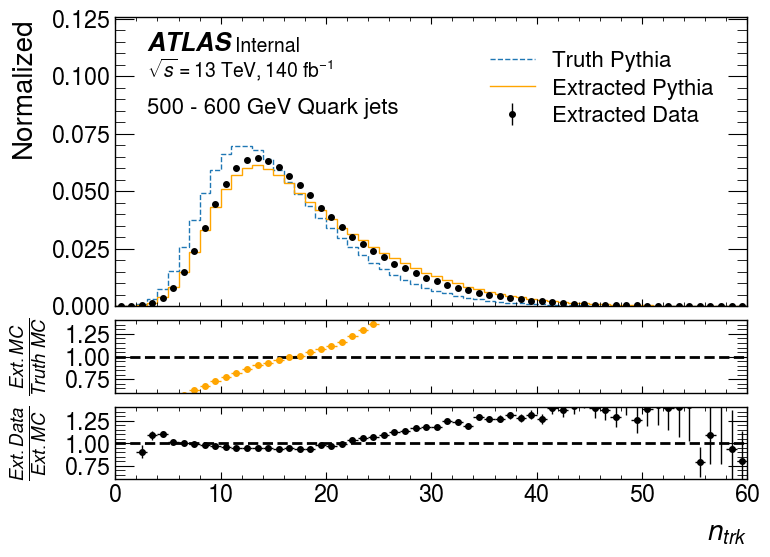

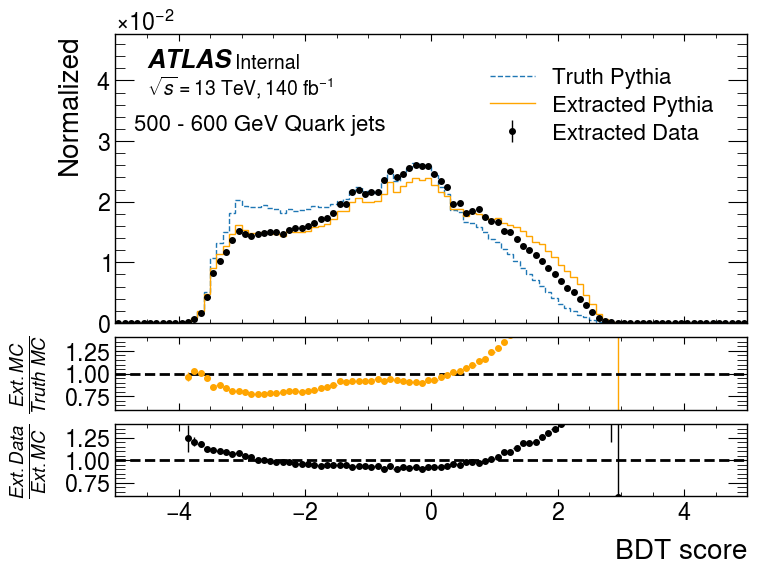

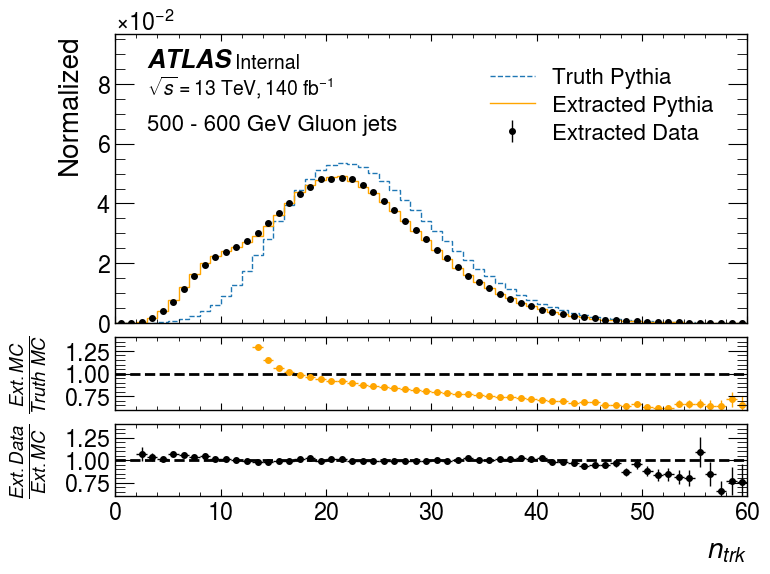

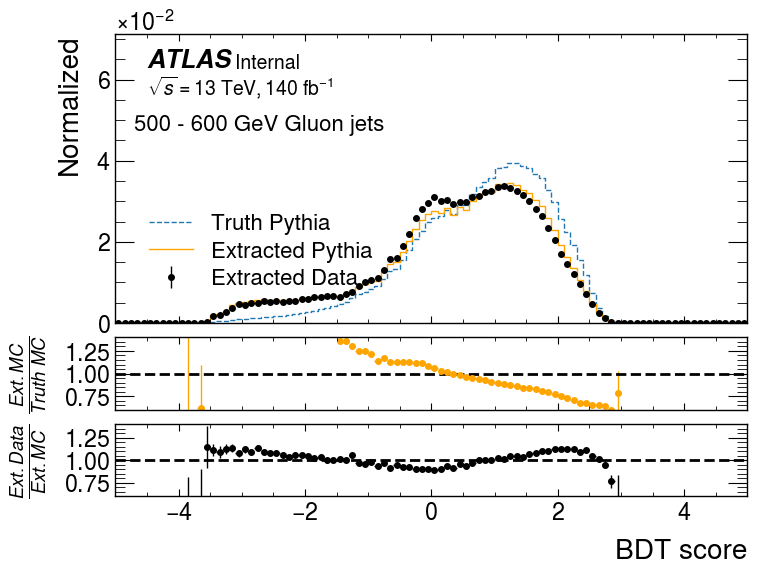

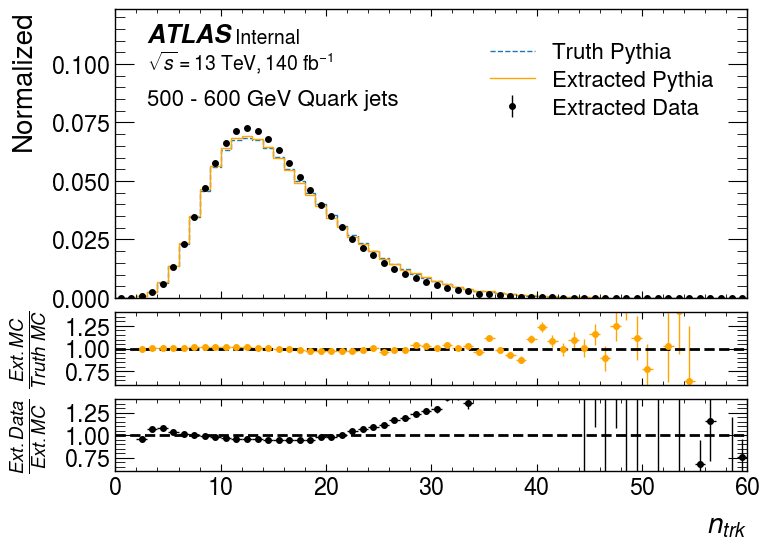

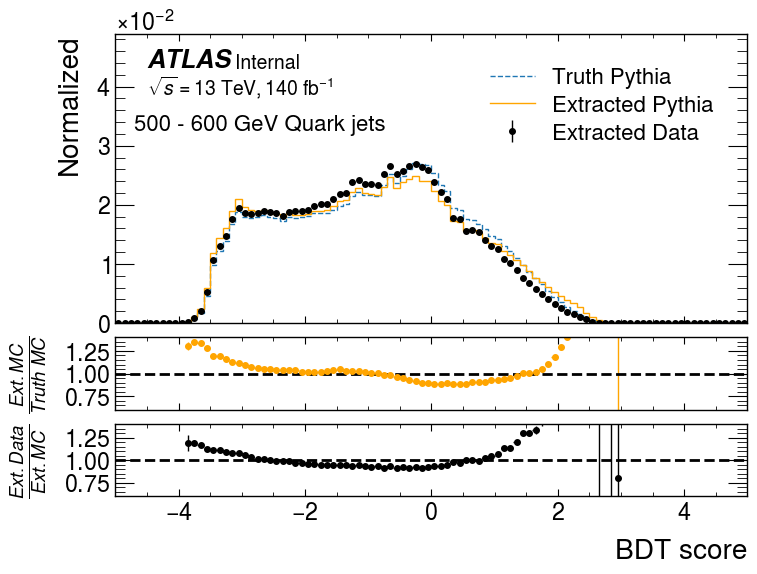

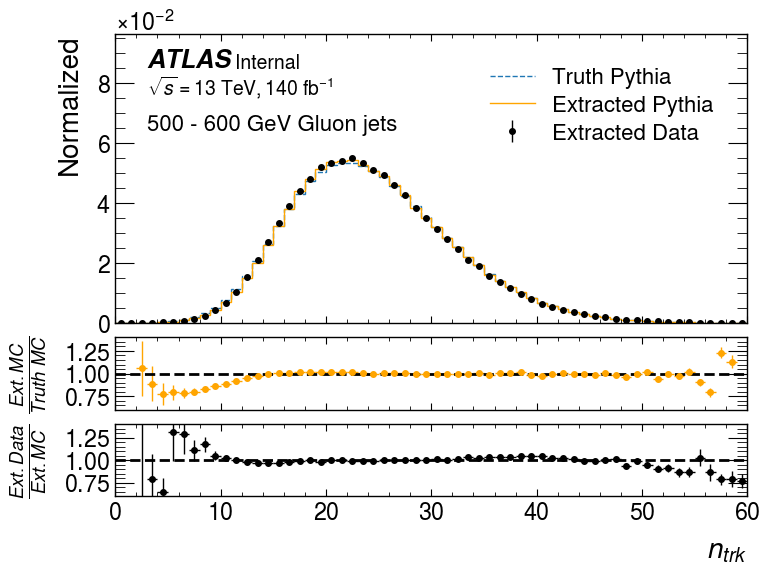

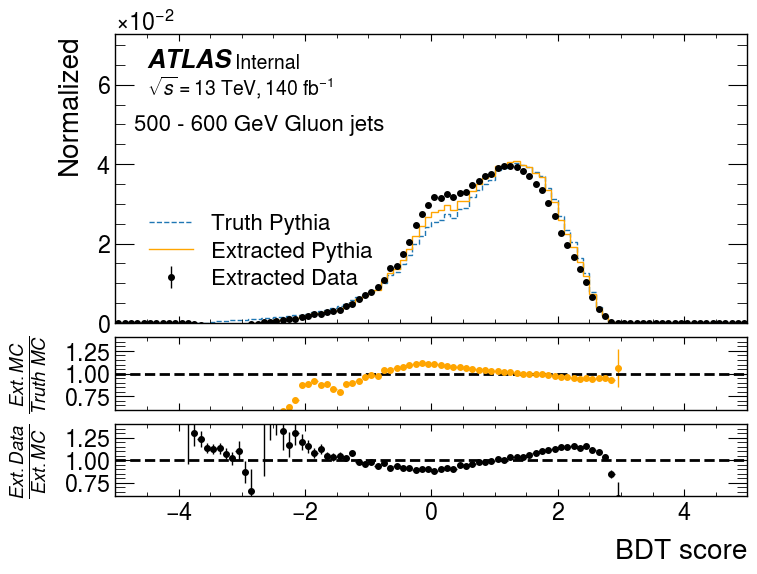

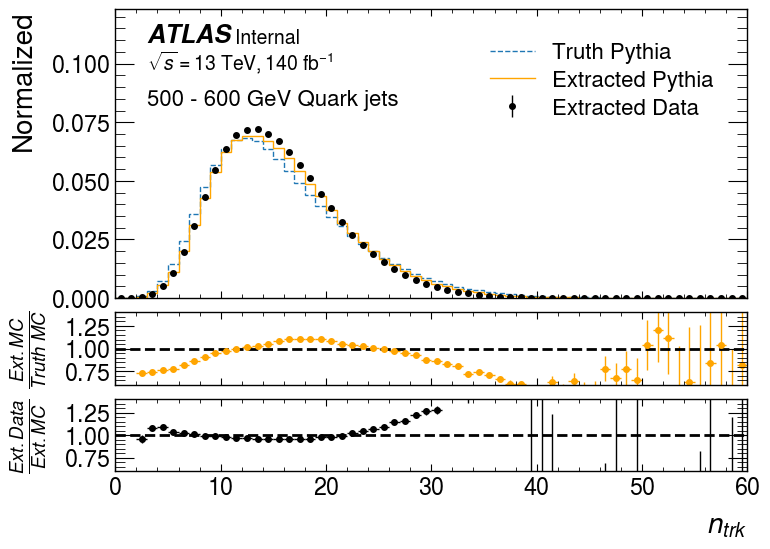

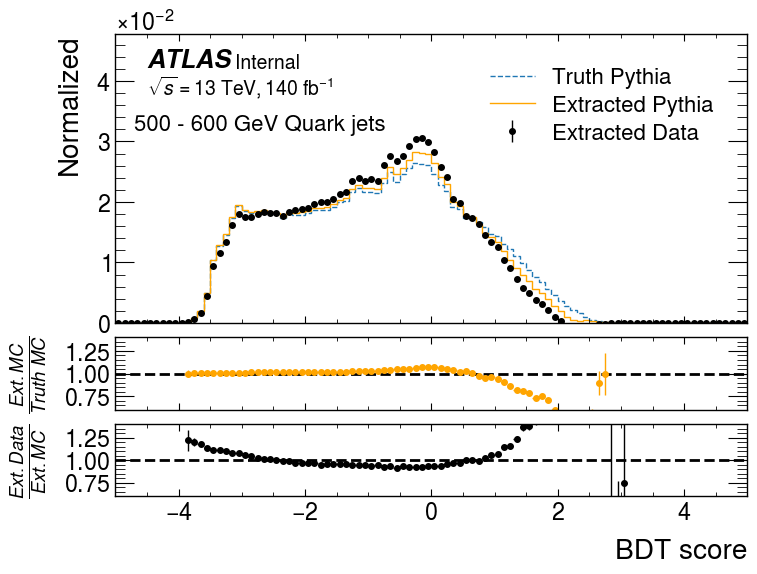

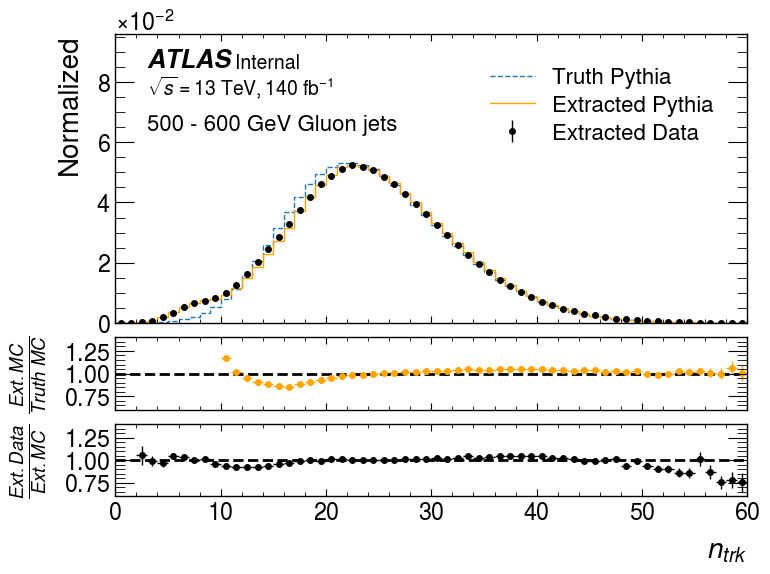

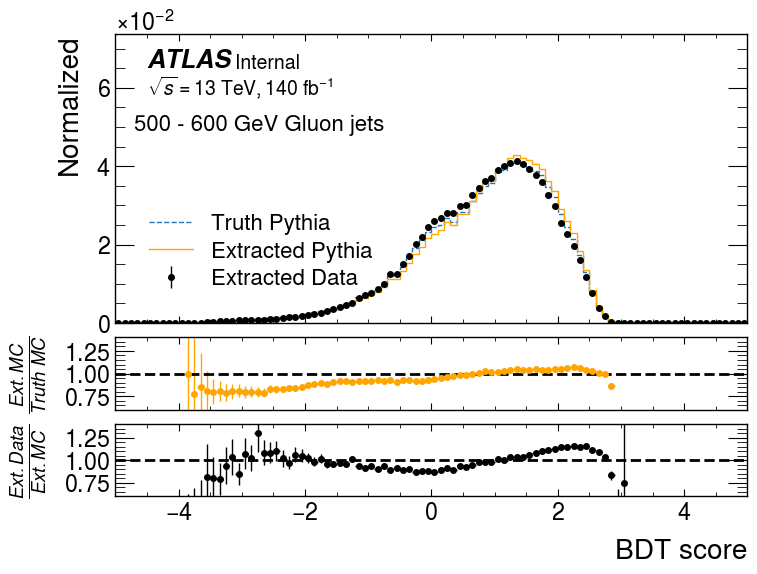

In [8]:
SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for i_pt, pt in enumerate(label_ptrange[:1]):
    for rvar in reweighting_vars:
        #bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        for parton in partons:
            #fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

            for i, syst in enumerate(syst_list):
                syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
                Extraction_Results[syst]= joblib.load(syst_path / f'{rvar}_Extraction_Results.pkl' )

                for var in label_var: 
                    bin_edges = HistBins[var]
                    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [4, 1, 1], 'hspace': 0.1})


                    Extraction_var_pt =  Extraction_Results[syst][var][pt]
        
                    syst_truth = Extraction_Results[syst][var][pt][f'p_{parton}']        
                    syst_Q = Extraction_Results[syst][var][pt][f'extract_p_{parton}_MC']
                    #syst_data=Extraction_Results[syst][var][pt][f'extract_p_{parton}_Data']
                    nom_data=Extraction_Results['nominal'][var][pt][f'extract_p_{parton}_Data']

                    y_max = np.max(unumpy.nominal_values(syst_truth))


                    hep.histplot(unumpy.nominal_values(syst_truth),bins=bin_edges,label=f'Truth Pythia',ax=ax0,histtype='step',linestyle='--',lw=2)
                    hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=f'Extracted Pythia',ax=ax0,histtype='step',linestyle='-',color='orange',lw=2)
                    #hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=Map_gen[syst],ax=ax0,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(syst_Q),markersize=5)#,color=ind_all[i])
                    hep.histplot(unumpy.nominal_values(nom_data),bins=bin_edges,label='Extracted Data',ax=ax0,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(nom_data),markersize=8)

                
                    ax0.set_ylim(0, y_max * 1.8)
                    ytext=y_max * 1.2
                    ax0.set_ylabel("Normalized",fontsize=20)
                    hep.atlas.label(label='Internal',ax=ax0,data=True,lumi=140)

                    ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(syst_Q,nom_data)

                    ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,syst_truth)
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='errorbar',marker=".",xerr=True,yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),markersize=8,color='orange')
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC2),bins=bin_edges,ax=ax2,histtype='errorbar',marker=".",xerr=True,color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC2),markersize=8)

                    ax1.set_ylim(0.6,1.4)
                    ax2.set_ylim(0.6,1.4)
                    #ax1.set_ylabel("MC closure",loc='center',fontsize=15)
                    #ax1.set_ylabel("Ratio to Data",loc='center',fontsize=15)
                    ax1.set_ylabel(r"$\frac{Ext.MC}{Truth~MC}$",loc='center',fontsize=19)
                    ax2.set_ylabel(r"$\frac{Ext.Data}{Ext.MC}$",loc='center',fontsize=19)
                    if var == 'GBDT_newScore' and parton == 'Gluon':
                        ax0.legend(loc='lower left',fontsize=16)
                    else:
                        ax0.legend(loc='upper right',fontsize=16)
                    ax0.text(bin_edges[3],ytext,f'{pt} < '+ r'$p_{\mathrm{T}}$'+ f' < {label_ptrange[i_pt+1]} GeV',fontsize=15)
                    ax1.set_xlim(bin_edges[0], bin_edges[-1])
                    ax2.set_xlim(bin_edges[0], bin_edges[-1])
                    ax2.set_xlabel(f"{Map_var_title[var]}")
                    ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
                    ax2.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

                    fig.savefig(f'../mcclosure_sf/mcclosure_{rvar}_{parton}_{pt}_{var}_SF.pdf')
         

/tmp/ipykernel_92889/45264139.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [4, 1, 1], 'hspace': 0.1})


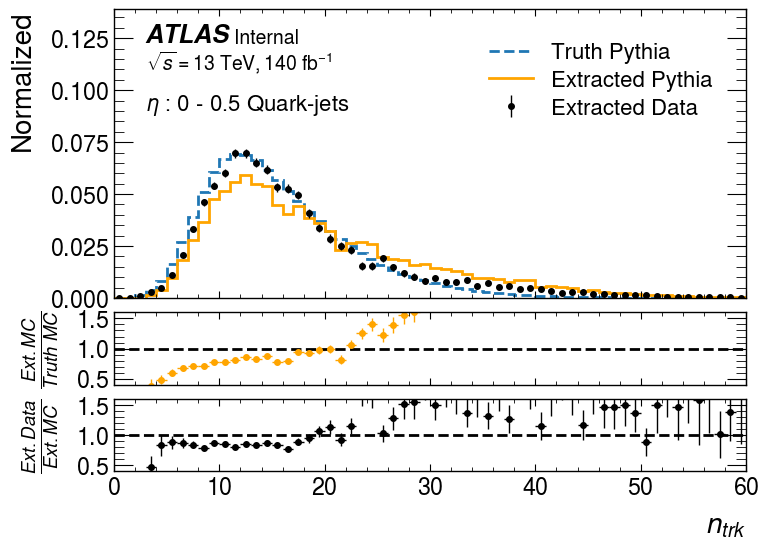

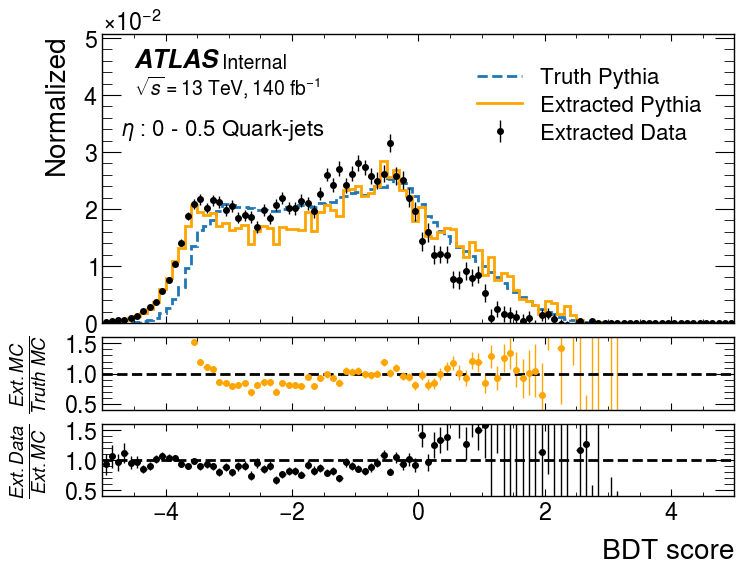

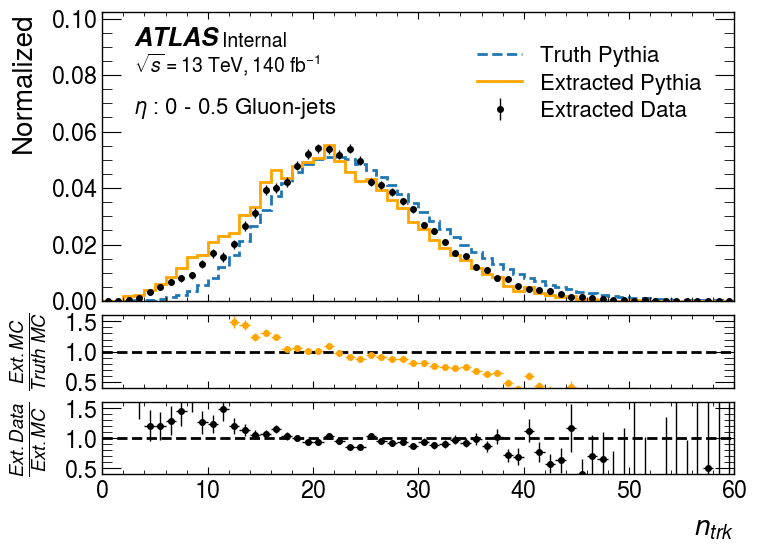

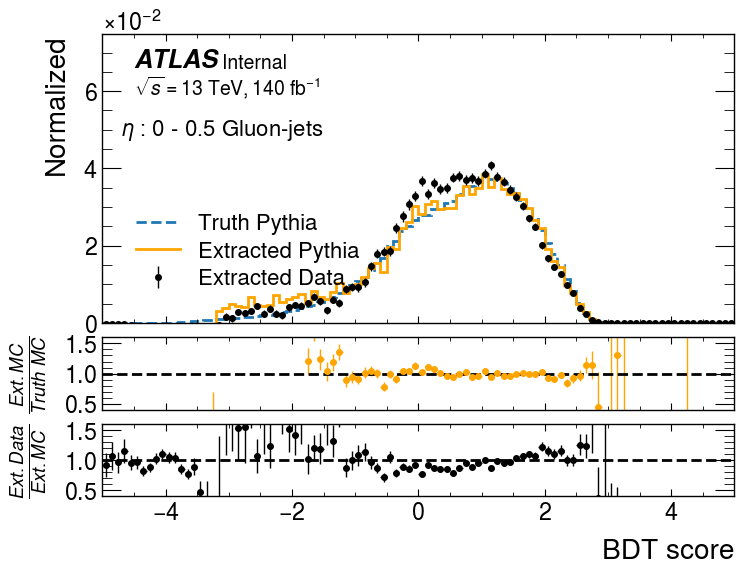

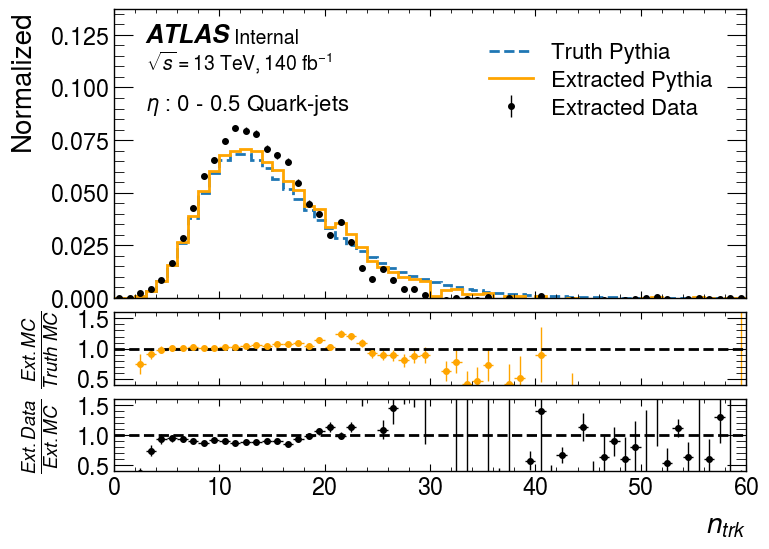

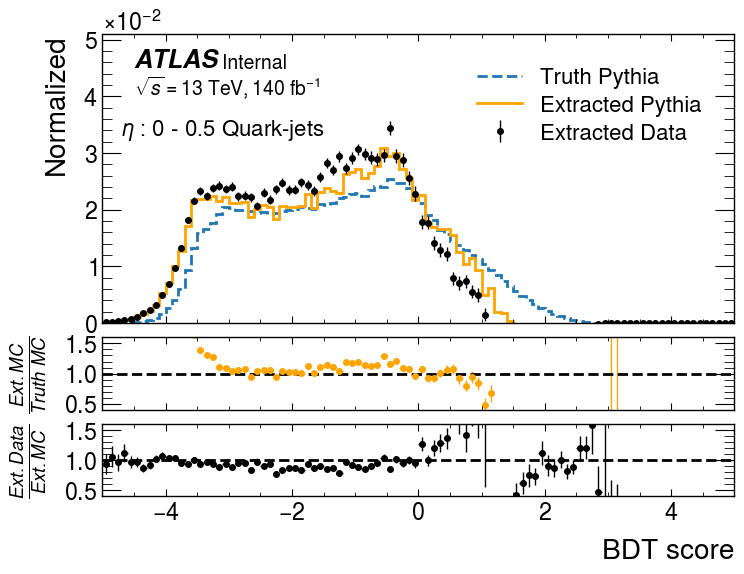

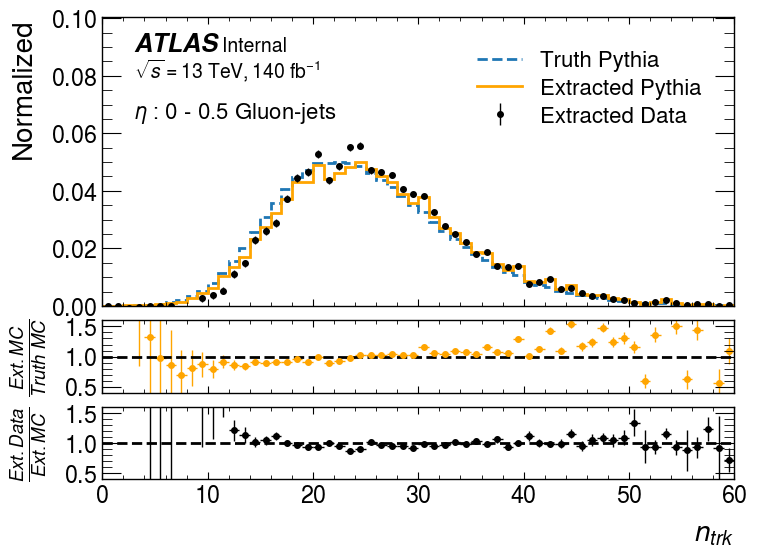

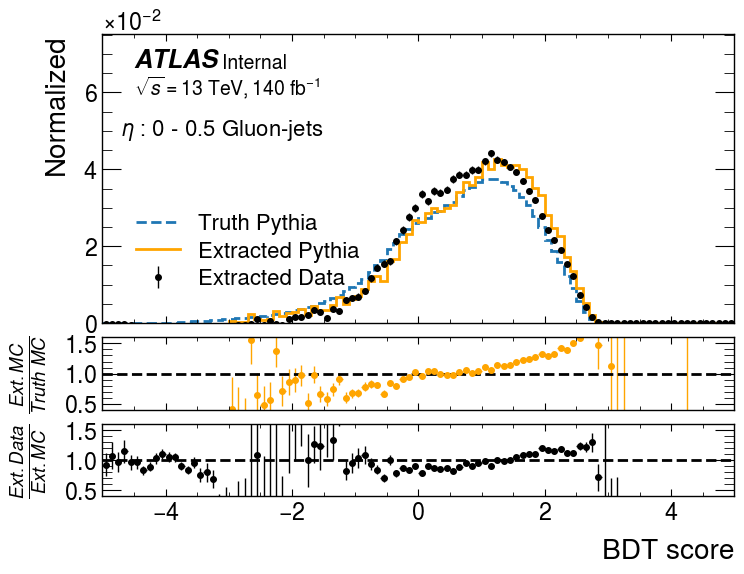

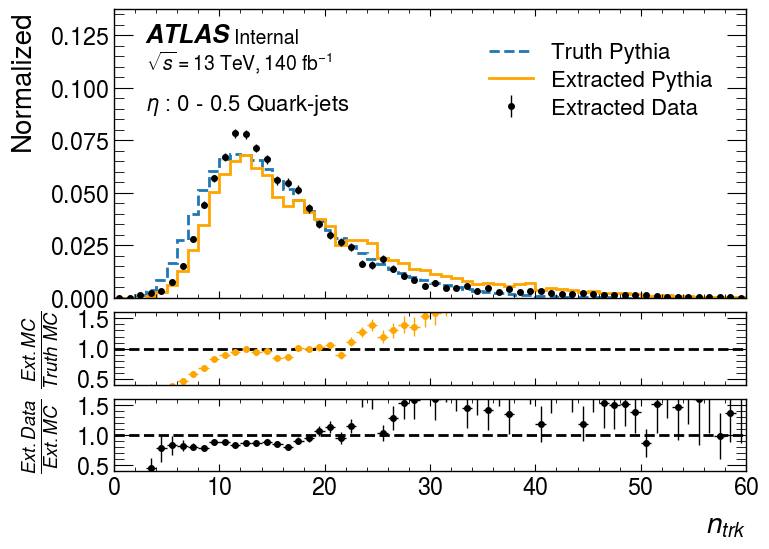

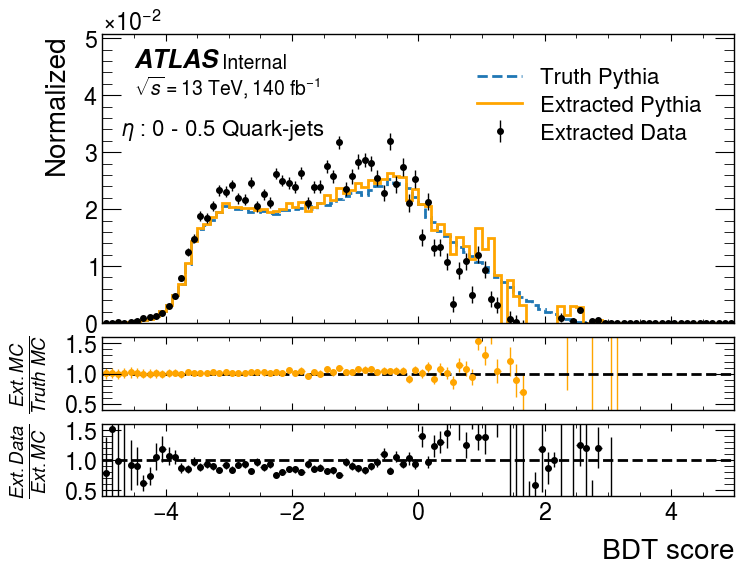

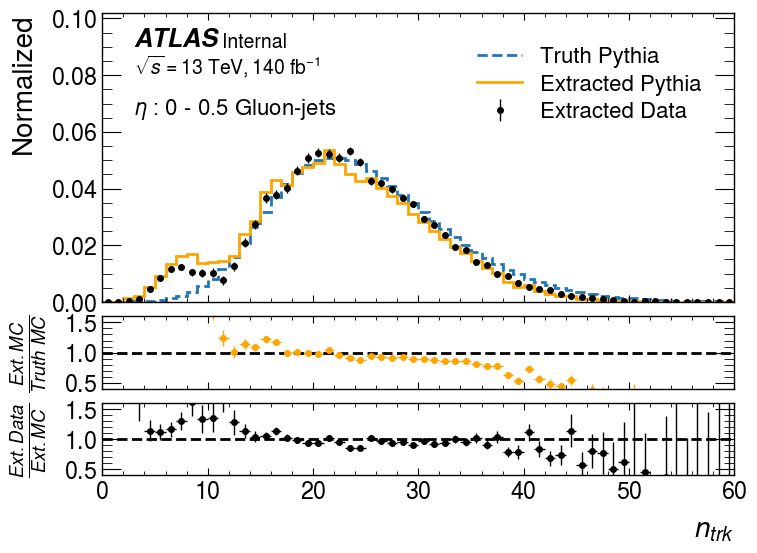

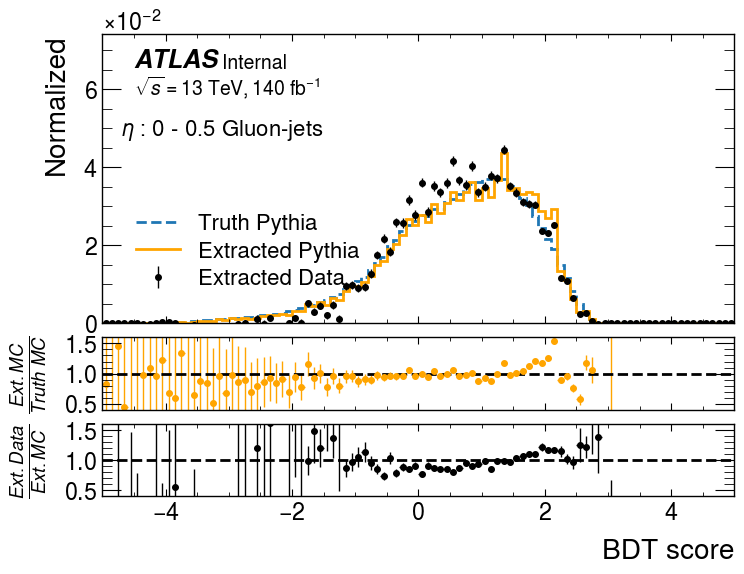

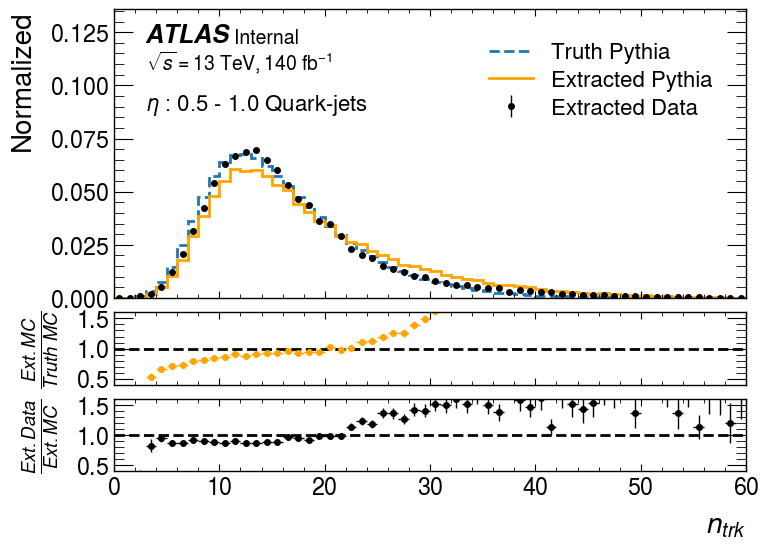

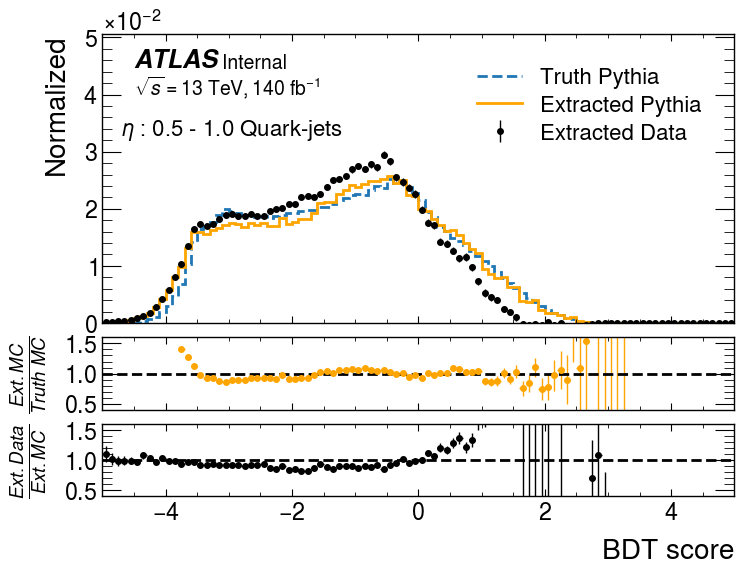

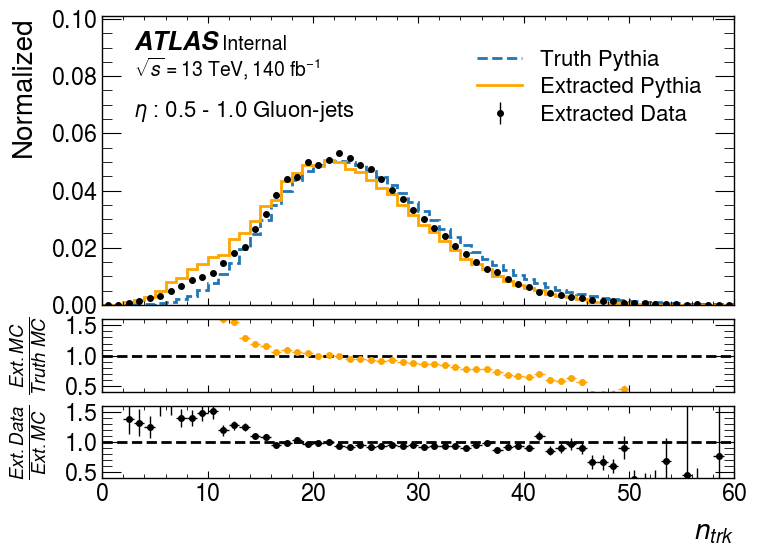

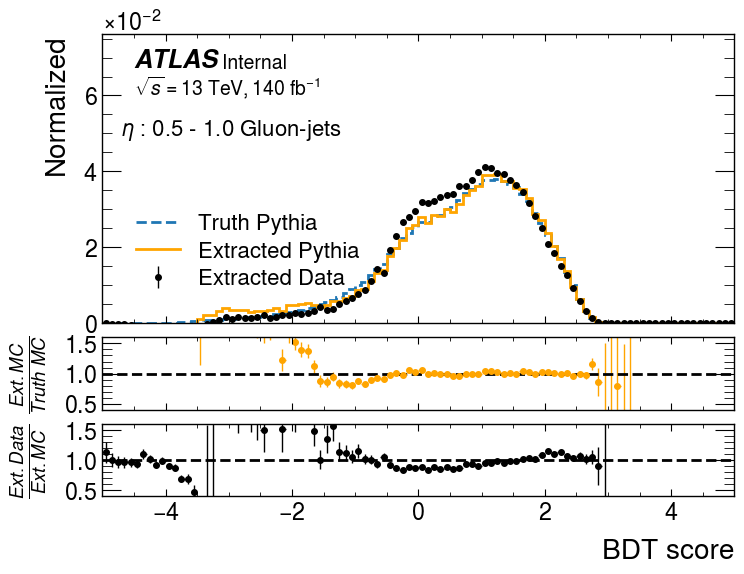

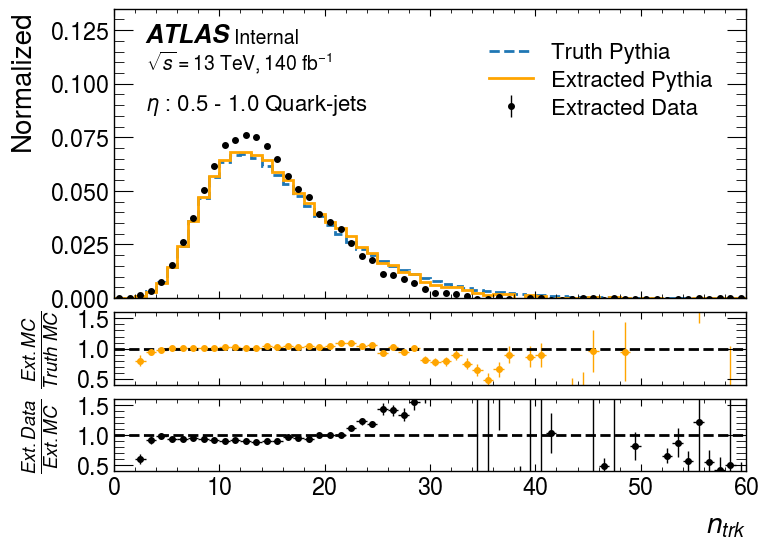

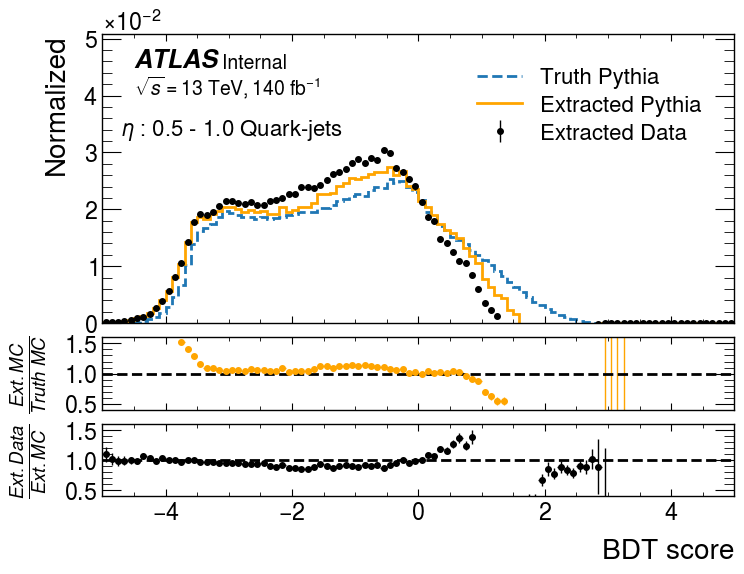

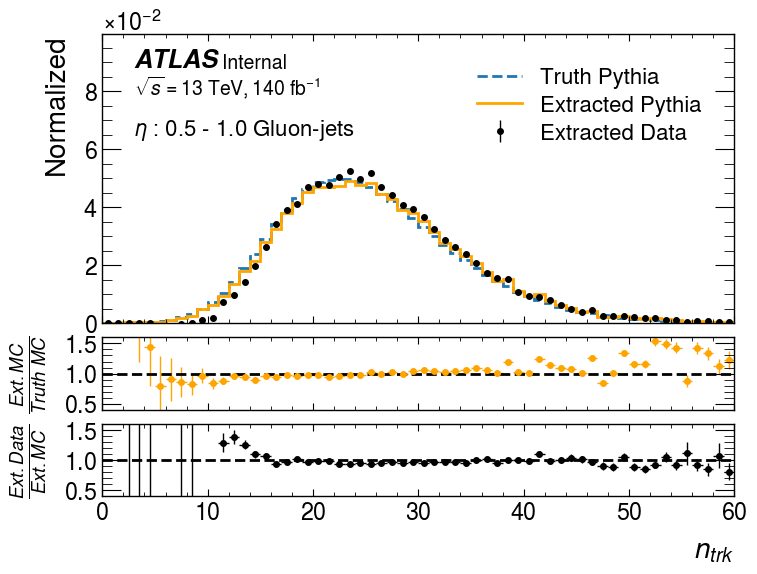

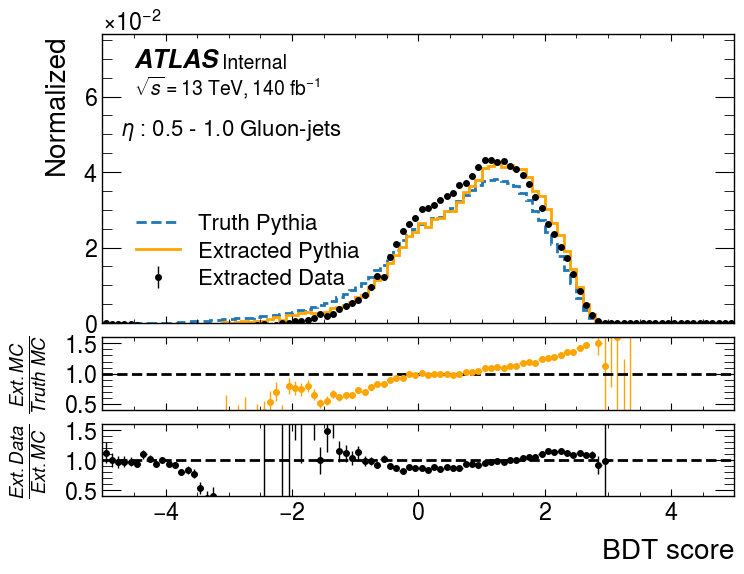

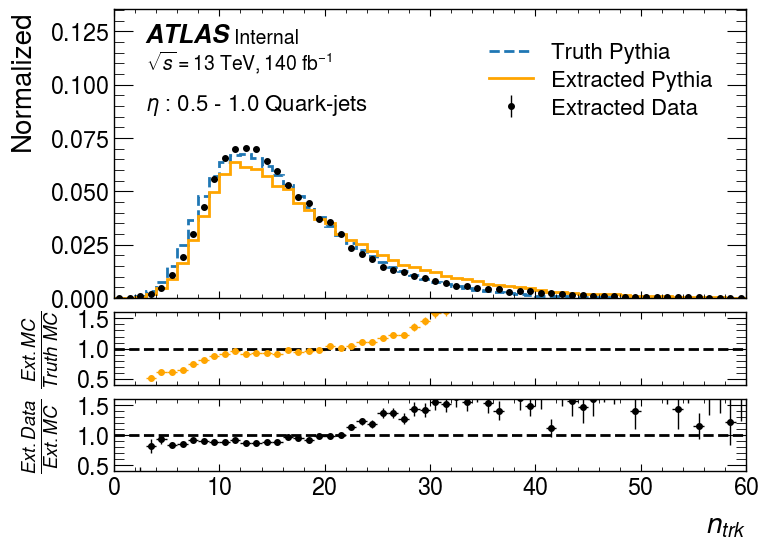

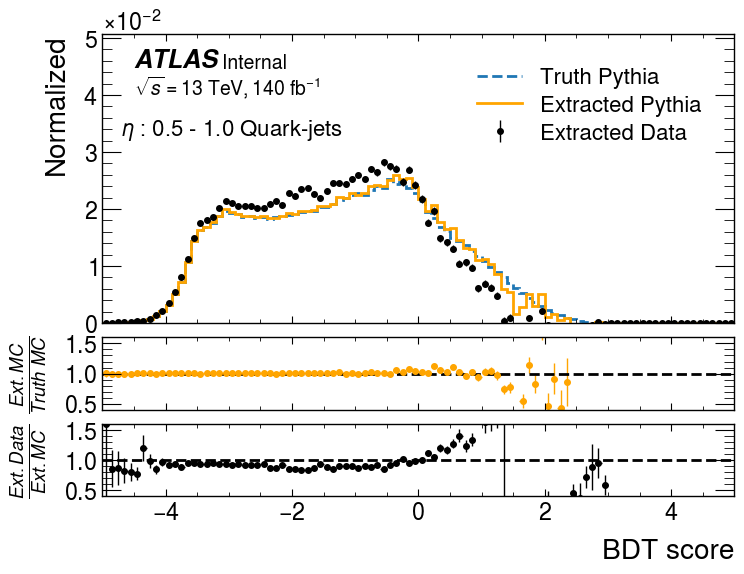

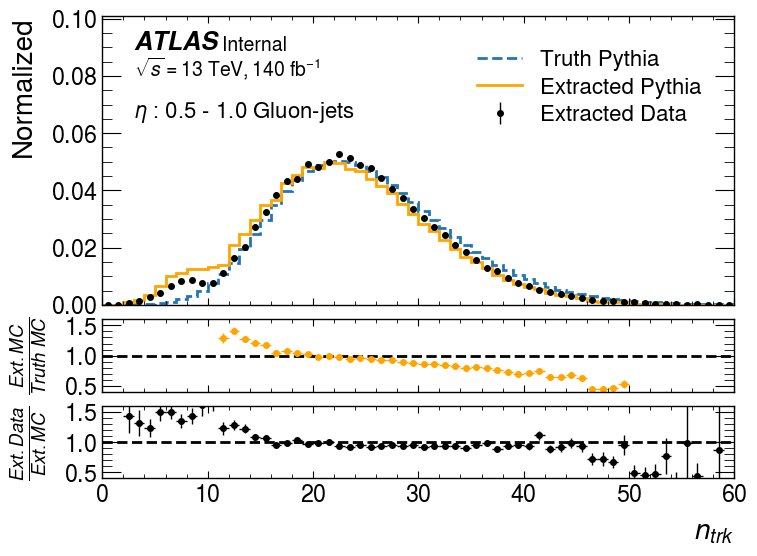

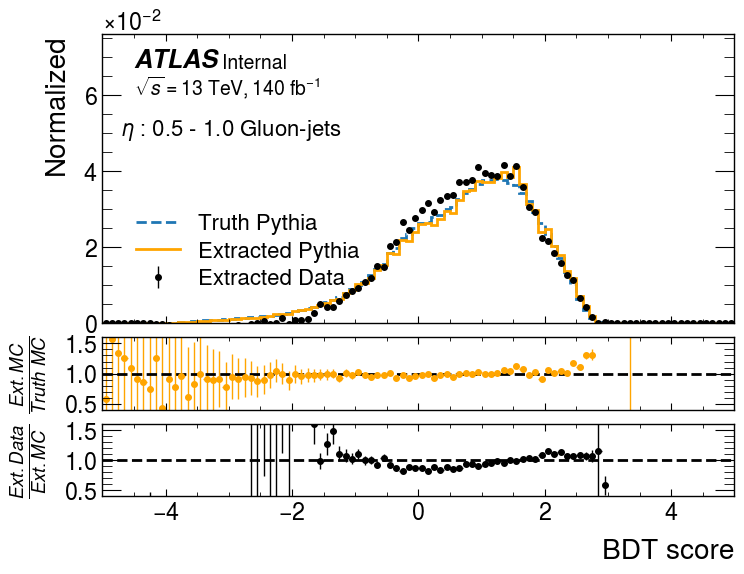

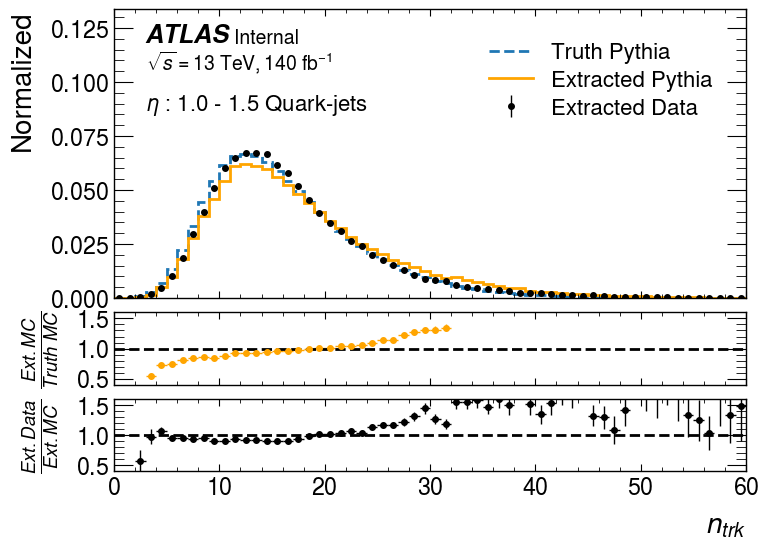

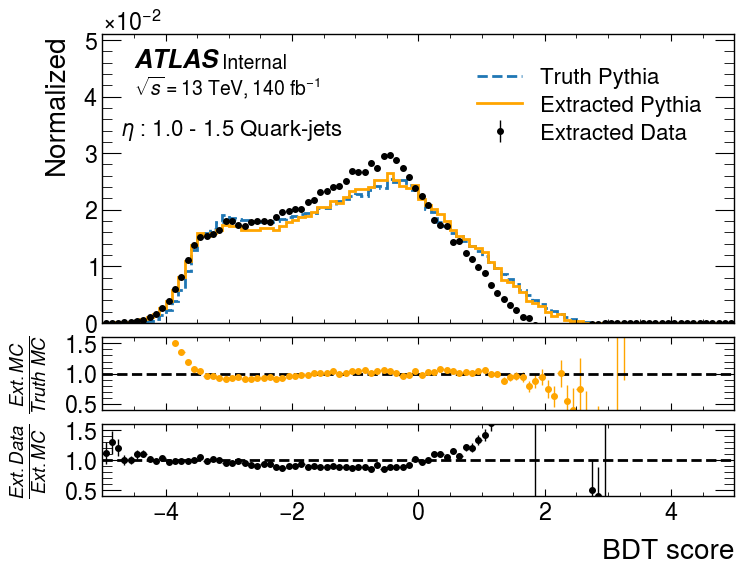

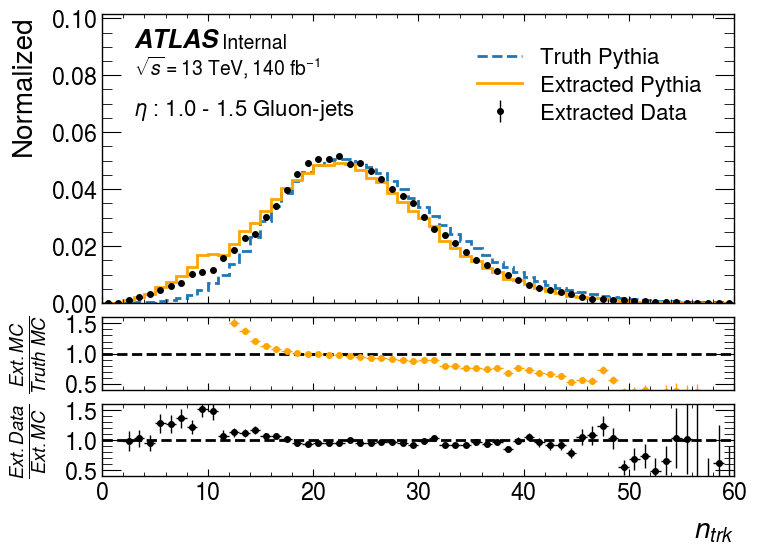

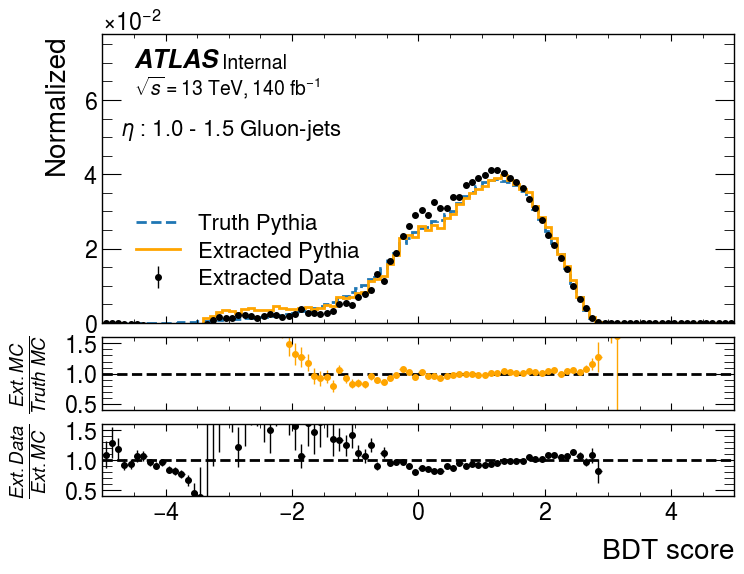

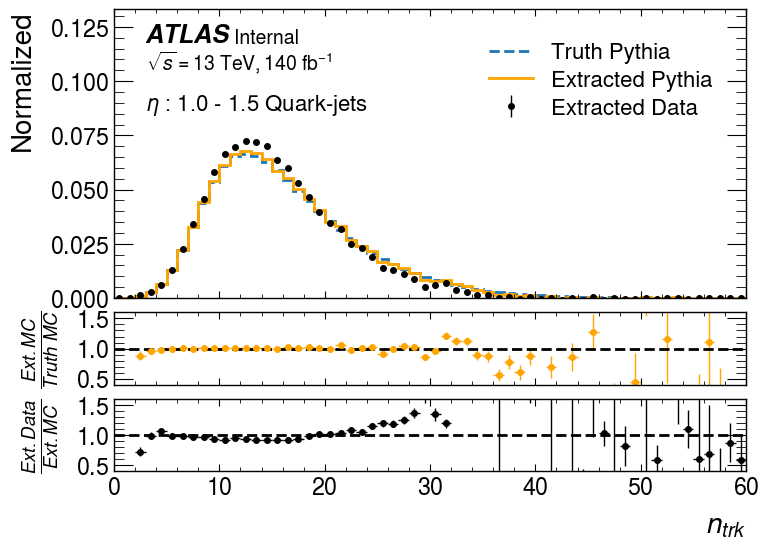

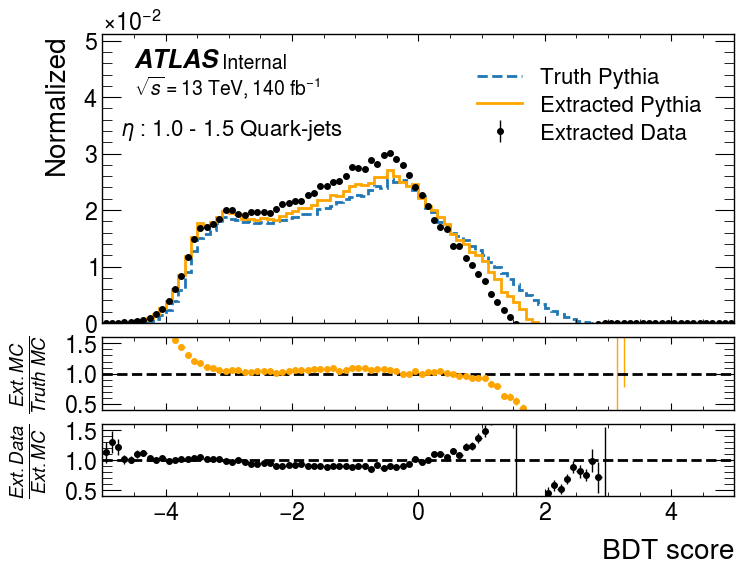

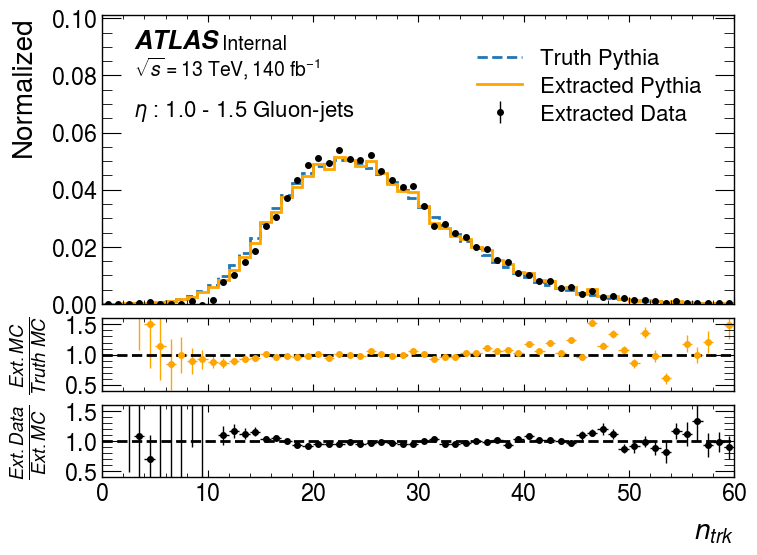

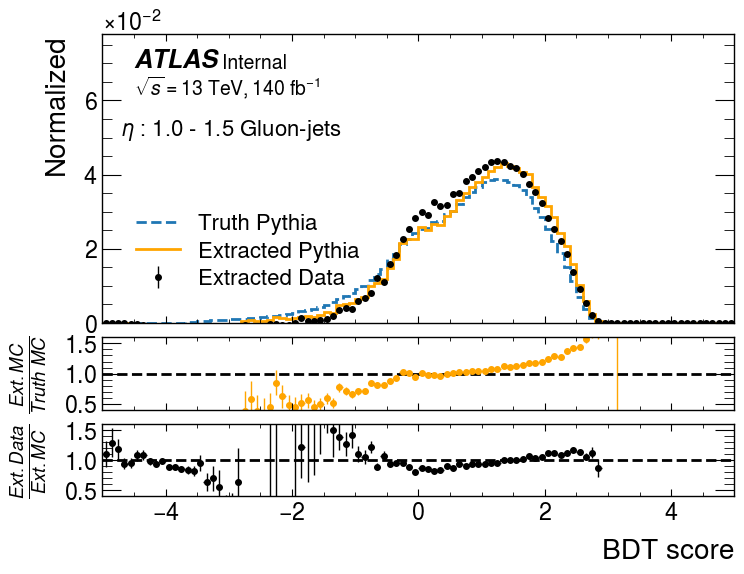

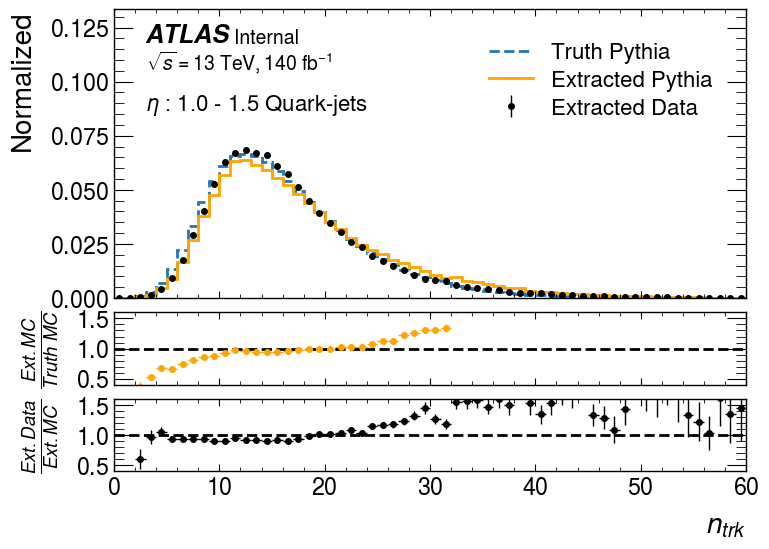

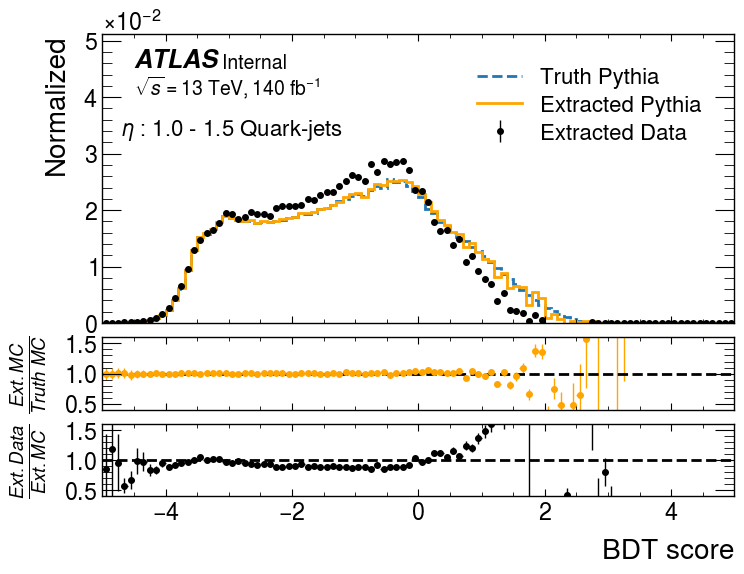

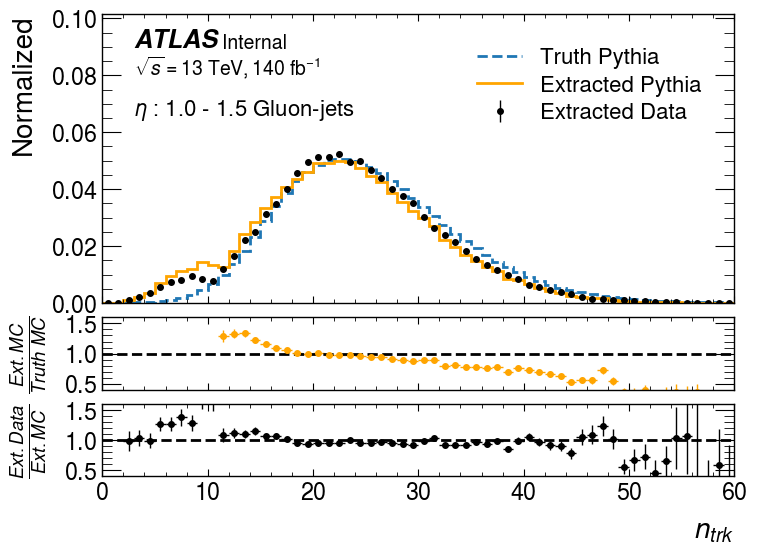

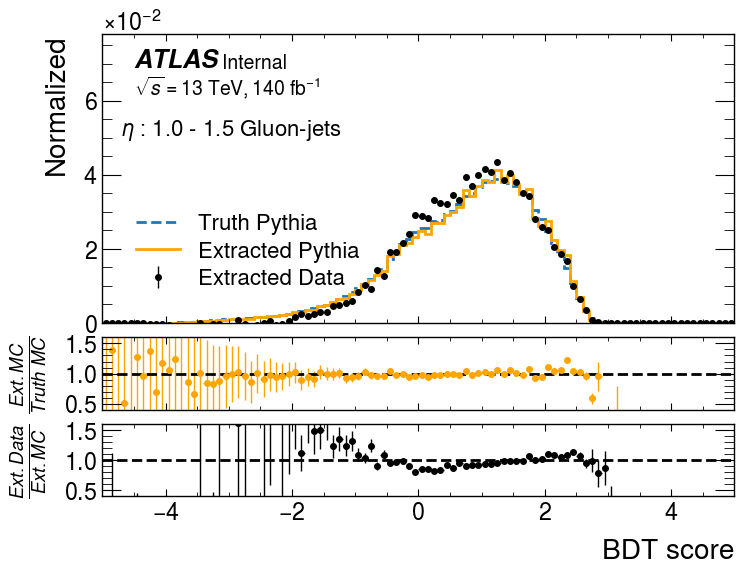

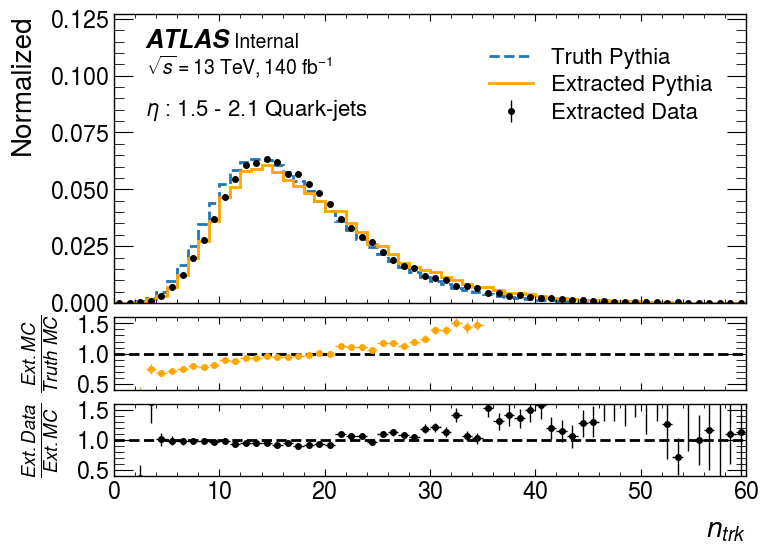

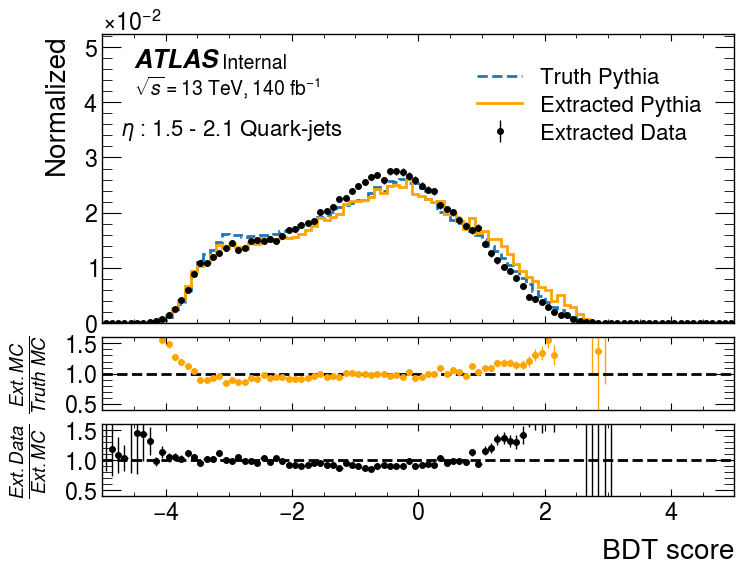

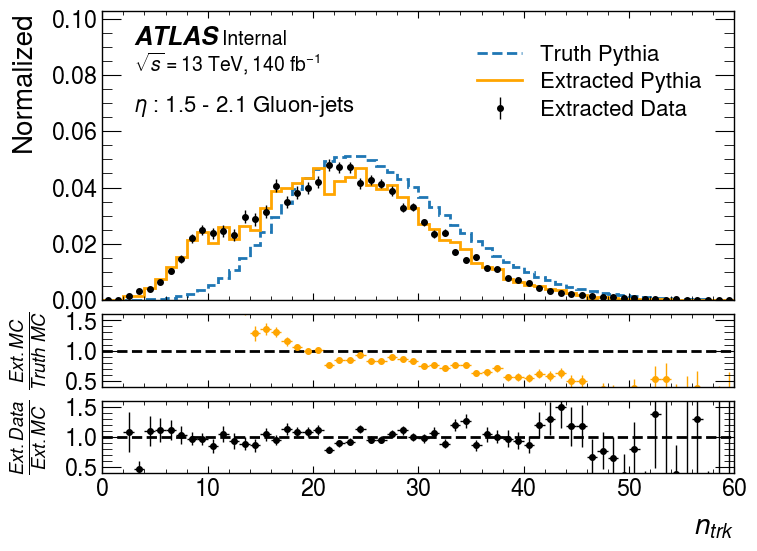

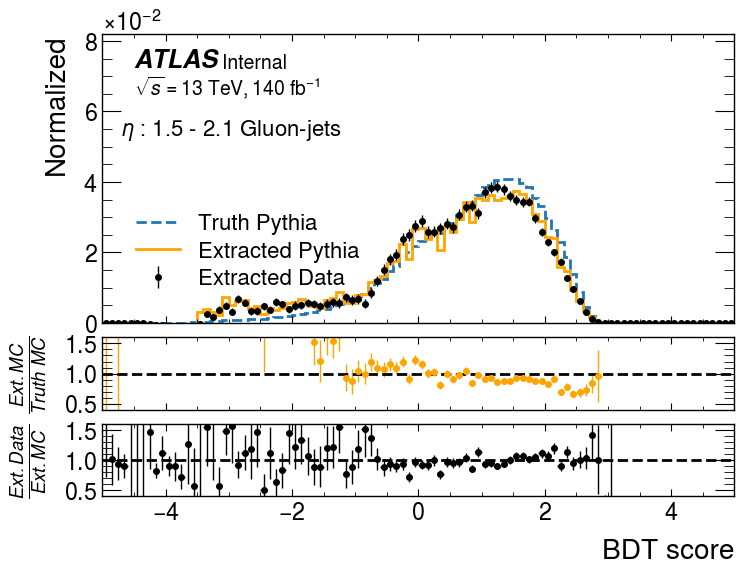

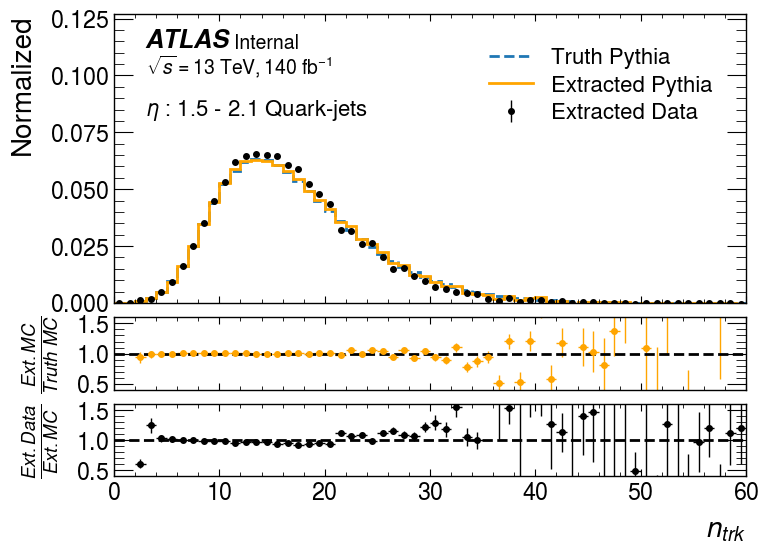

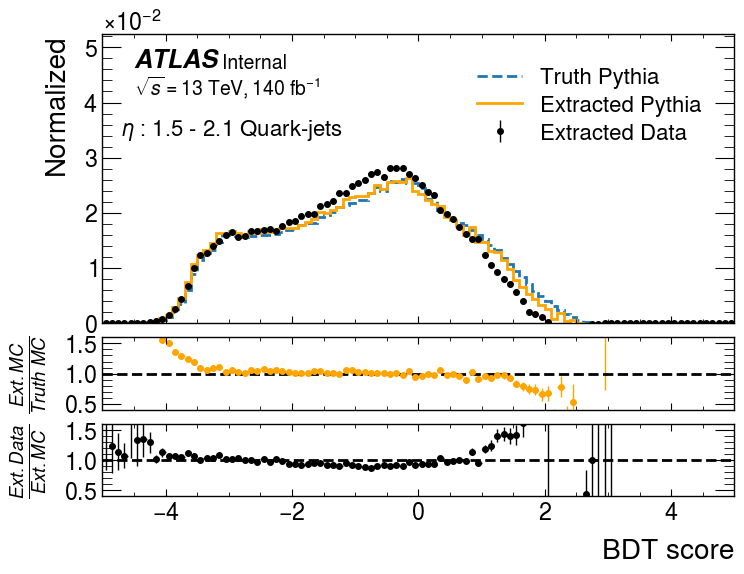

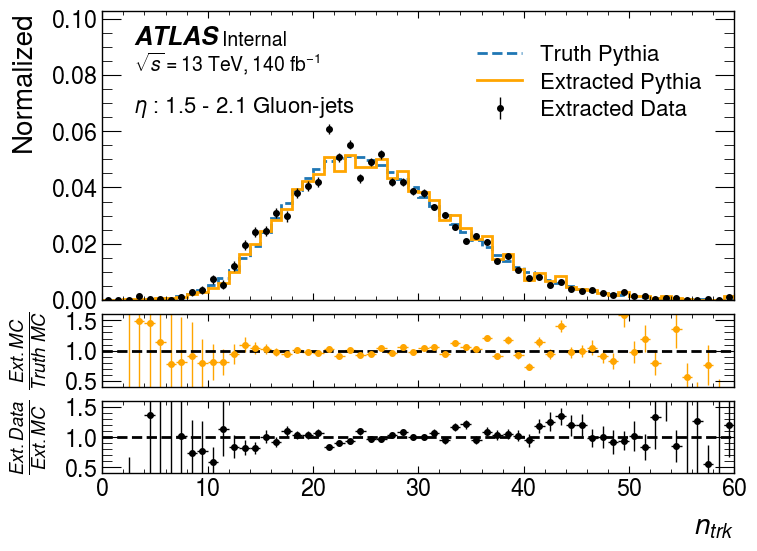

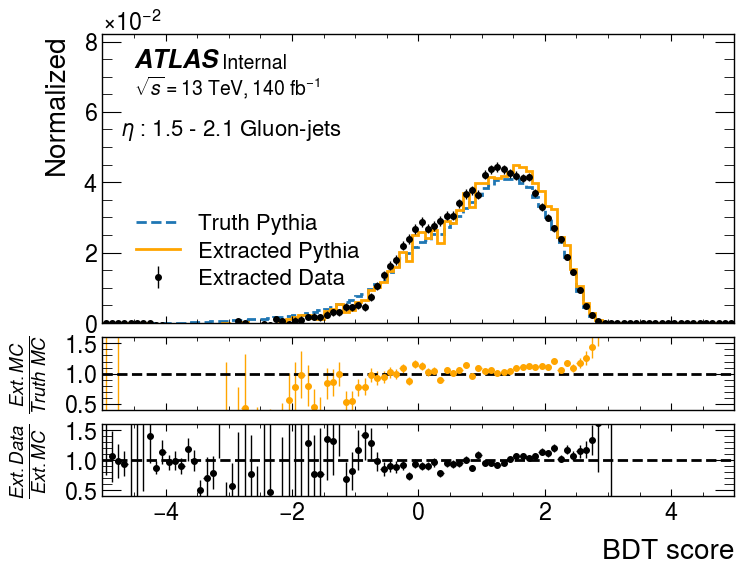

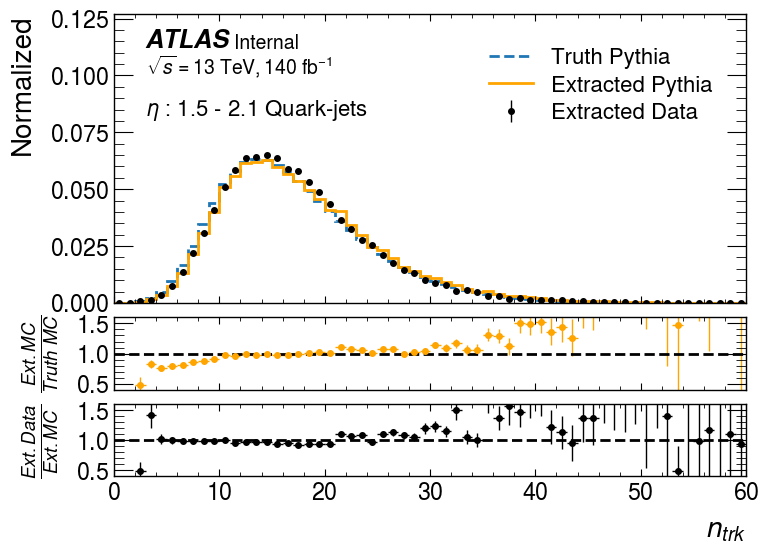

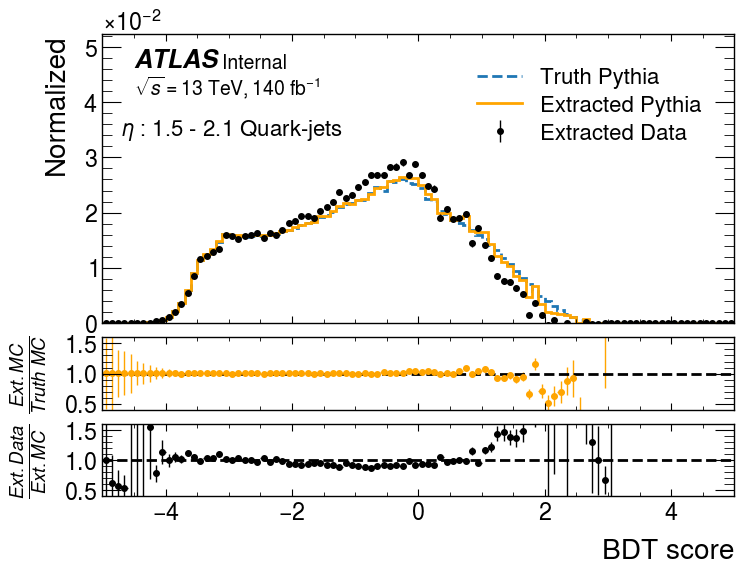

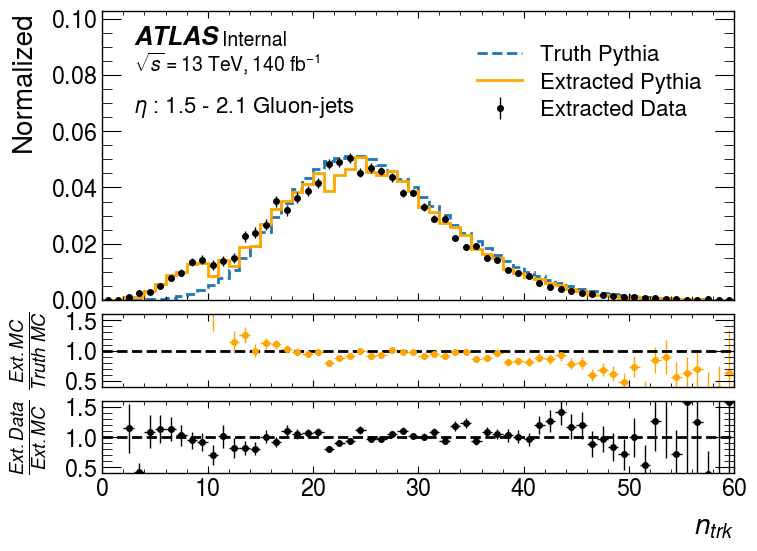

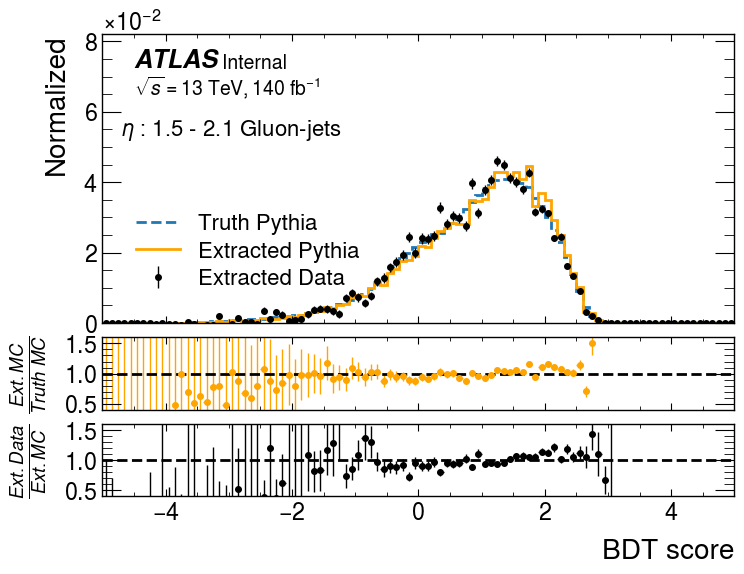

In [11]:
SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


pkl_path = Path('/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/eta_dependency_eta_bin/nominal_eta_binned/nominal')


for i_pt, pt in enumerate(label_eta_bin[:-1]):
    for rvar in reweighting_vars:
        #bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        for parton in partons:
            #fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

            for i, syst in enumerate(syst_list):
                syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
                Extraction_Results[syst]= joblib.load(syst_path / f'{rvar}_Extraction_Results.pkl' )

                for var in label_var: 
                    bin_edges = HistBins[var]
                    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [4, 1, 1], 'hspace': 0.1})


                    Extraction_var_pt =  Extraction_Results[syst][var][pt]
        
                    syst_truth = Extraction_Results[syst][var][pt][f'p_{parton}']        
                    syst_Q = Extraction_Results[syst][var][pt][f'extract_p_{parton}_MC']
                    #syst_data=Extraction_Results[syst][var][pt][f'extract_p_{parton}_Data']
                    nom_data=Extraction_Results['nominal'][var][pt][f'extract_p_{parton}_Data']

                    y_max = np.max(unumpy.nominal_values(syst_truth))


                    hep.histplot(unumpy.nominal_values(syst_truth),bins=bin_edges,label=f'Truth Pythia',ax=ax0,histtype='step',linestyle='--',lw=2)
                    hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=f'Extracted Pythia',ax=ax0,histtype='step',linestyle='-',color='orange',lw=2)
                    #hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=Map_gen[syst],ax=ax0,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(syst_Q),markersize=5)#,color=ind_all[i])
                    hep.histplot(unumpy.nominal_values(nom_data),bins=bin_edges,label='Extracted Data',ax=ax0,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(nom_data),markersize=8)

                
                    ax0.set_ylim(0, y_max * 2)
                    ytext=y_max * 1.3
                    ax0.set_ylabel("Normalized",fontsize=20)
                    hep.atlas.label(label='Internal',ax=ax0,data=True,lumi=140)

                    ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(syst_Q,nom_data)

                    ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,syst_truth)
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='errorbar',marker=".",xerr=True,yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),markersize=8,color='orange')
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC2),bins=bin_edges,ax=ax2,histtype='errorbar',marker=".",xerr=True,color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC2),markersize=8)

                    ax1.set_ylim(0.4,1.6)
                    ax2.set_ylim(0.4,1.6)
                    #ax1.set_ylabel("MC closure",loc='center',fontsize=15)
                    #ax1.set_ylabel("Ratio to Data",loc='center',fontsize=15)
                    ax1.set_ylabel(r"$\frac{Ext.MC}{Truth~MC}$",loc='center',fontsize=19)
                    ax2.set_ylabel(r"$\frac{Ext.Data}{Ext.MC}$",loc='center',fontsize=19)
                    if var == 'GBDT_newScore' and parton == 'Gluon':
                        ax0.legend(loc='lower left',fontsize=16)
                    else:
                        ax0.legend(loc='upper right',fontsize=16)

                    ax0.text(bin_edges[3],ytext,rf'$\eta$ : {pt} - {label_eta_bin[i_pt+1]} {parton}-jets',fontsize=16)
                    ax1.set_xlim(bin_edges[0], bin_edges[-1])
                    ax2.set_xlim(bin_edges[0], bin_edges[-1])
                    ax2.set_xlabel(f"{Map_var_title[var]}")
                    ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
                    ax2.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

                    fig.savefig(f'../mcclosure_etabin/mcclosure_{rvar}_{parton}_{pt}_{var}_SF.pdf')
         

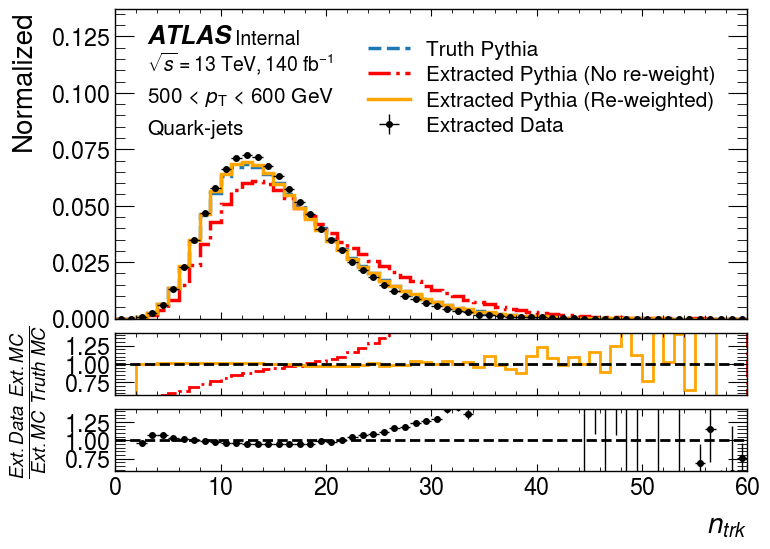

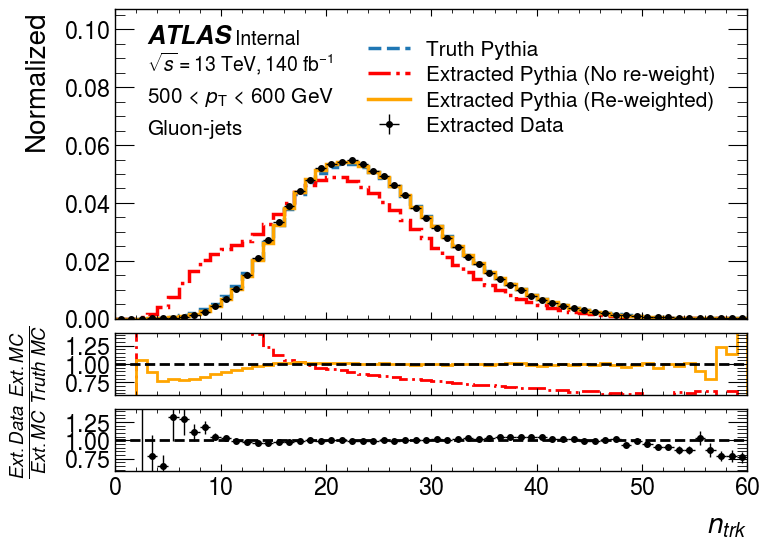

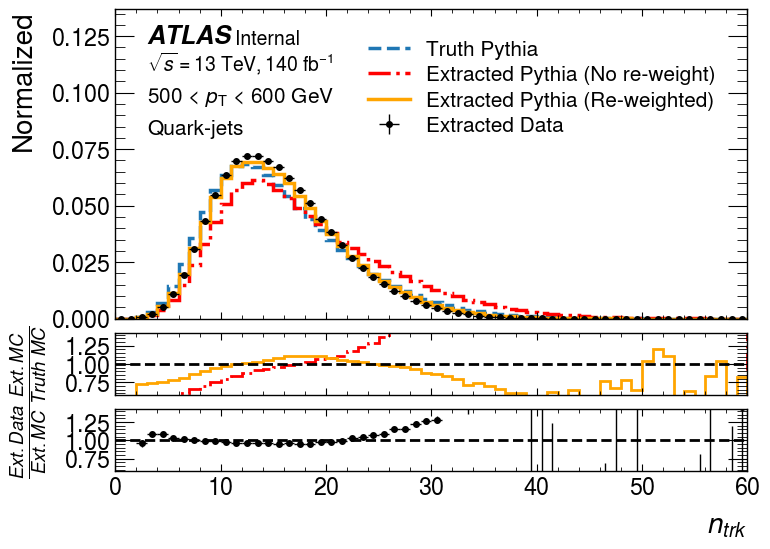

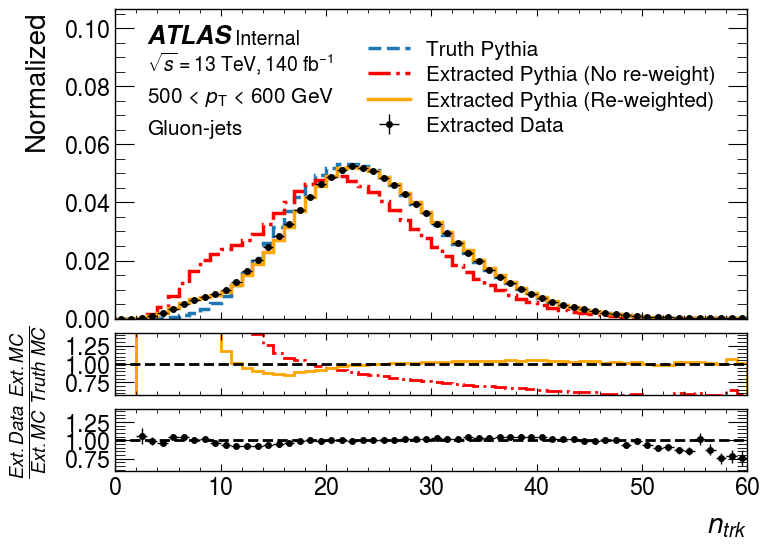

In [6]:
SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for i_pt, pt in enumerate(label_ptrange[:1]):#label_ptrange[:-1]
    for rvar in reweighting_vars[1:]:
        #bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        for parton in partons:
            #fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

            for i, syst in enumerate(syst_list):
                syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
                Extraction_Results[syst]= joblib.load(syst_path / f'{rvar}_Extraction_Results.pkl' )
                Extraction_Results_none = joblib.load(syst_path / f'none_Extraction_Results.pkl' )

                for var in label_var[:1]: 
                    bin_edges = HistBins[var]
                    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1], 'hspace': 0.1})


                    Extraction_var_pt =  Extraction_Results[syst][var][pt]
                    Extraction_var_pt_none =  Extraction_Results_none[var][pt]
        
                    syst_truth = Extraction_Results[syst][var][pt][f'p_{parton}']        
                    syst_Q = Extraction_Results[syst][var][pt][f'extract_p_{parton}_MC']
                    syst_Q_none = Extraction_var_pt_none[f'extract_p_{parton}_MC']
                    #syst_data=Extraction_Results[syst][var][pt][f'extract_p_{parton}_Data']
                    nom_data=Extraction_Results['nominal'][var][pt][f'extract_p_{parton}_Data']

                    y_max = np.max(unumpy.nominal_values(syst_truth))


                    hep.histplot(unumpy.nominal_values(syst_truth),bins=bin_edges,label=f'Truth Pythia',ax=ax0,histtype='step',linestyle='--',lw=2.5)
                    hep.histplot(unumpy.nominal_values(syst_Q_none),bins=bin_edges,label=f'Extracted Pythia (No re-weight)',ax=ax0,histtype='step',color='red',linestyle='-.',lw=2.5)
                    hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=f'Extracted Pythia {Map_rvar[rvar]}',ax=ax0,histtype='step',color='orange',linestyle='-',lw=2.5)
                    #hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=Map_gen[syst],ax=ax0,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(syst_Q),markersize=5)#,color=ind_all[i])
                    hep.histplot(unumpy.nominal_values(nom_data),bins=bin_edges,label='Extracted Data',ax=ax0,histtype='errorbar',marker=".",color='black',xerr=True,yerr=unumpy.std_devs(nom_data),markersize=8)

                
                    ax0.set_ylim(0, y_max * 2)
                    ytext=y_max * 1.4
                    ax0.set_ylabel("Normalized",fontsize=20)
                    hep.atlas.label(label='Internal',ax=ax0,data=True,lumi=140)

                    ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(syst_Q,nom_data)

                    ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,syst_truth)
                    ratio_truthMC_over_extractedMC3 = safe_array_divide_unumpy(syst_Q_none,syst_truth)
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC3),bins=bin_edges,ax=ax1,label='No re-weight',histtype='step',color='red',linestyle='-.',lw=2)

                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='step',label='Re-weighted',color='orange',linestyle='-',lw=2)
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC2),bins=bin_edges,ax=ax2,histtype='errorbar',marker=".",xerr=True,color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC2),markersize=8)

                    ax1.set_ylim(0.58,1.42)
                    #ax1.legend()
                    ax2.set_ylim(0.58,1.42)
                    #ax1.set_ylabel("MC closure",loc='center',fontsize=15)
                    #ax1.set_ylabel("Ratio to Data",loc='center',fontsize=15)
                    ax1.set_ylabel(r"$\frac{Ext.MC}{Truth~MC}$",loc='center',fontsize=19)
                    ax2.set_ylabel(r"$\frac{Ext.Data}{Ext.MC}$",loc='center',fontsize=19)
                    ax0.legend(loc='upper right',fontsize=15)
                    # if var == 'GBDT_newScore' and parton == 'Gluon':
                    #     ax0.legend(loc='lower left',fontsize=15)
                    # else:
                    #     ax0.legend(loc='upper right',fontsize=15)

                    ax0.text(bin_edges[3],ytext,f'{pt} < '+ r'$p_{\mathrm{T}}$'+ f' < {label_ptrange[i_pt+1]} GeV',fontsize=15)

                    ax0.text(bin_edges[3],ytext*0.85,f'{parton}-jets',fontsize=15)
                    ax1.set_xlim(bin_edges[0], bin_edges[-1])
                    ax2.set_xlim(bin_edges[0], bin_edges[-1])
                    ax2.set_xlabel(f"{Map_var_title[var]}")
                    ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
                    ax2.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

                    fig.savefig(f'../mcclosure_sf/mcclosure_{rvar}_{parton}_{pt}_{var}_SF.pdf')
         

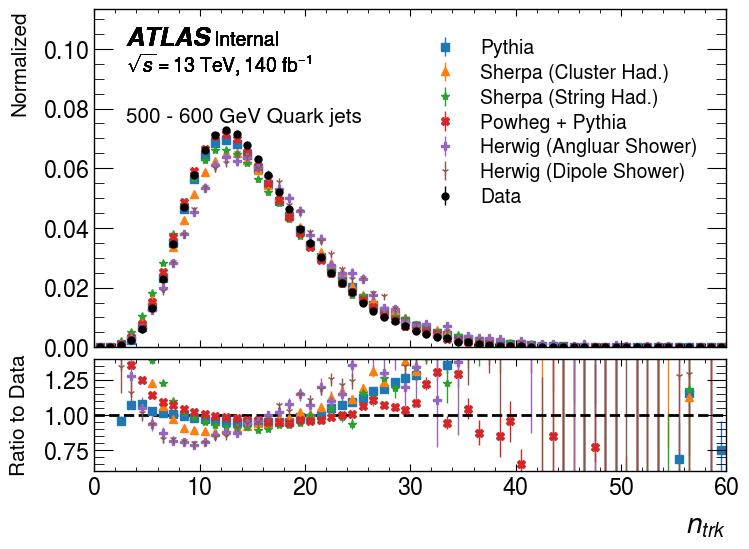

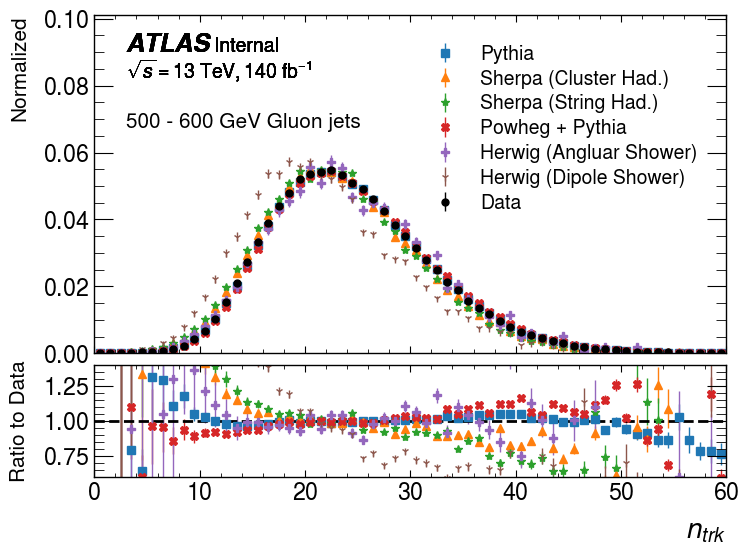

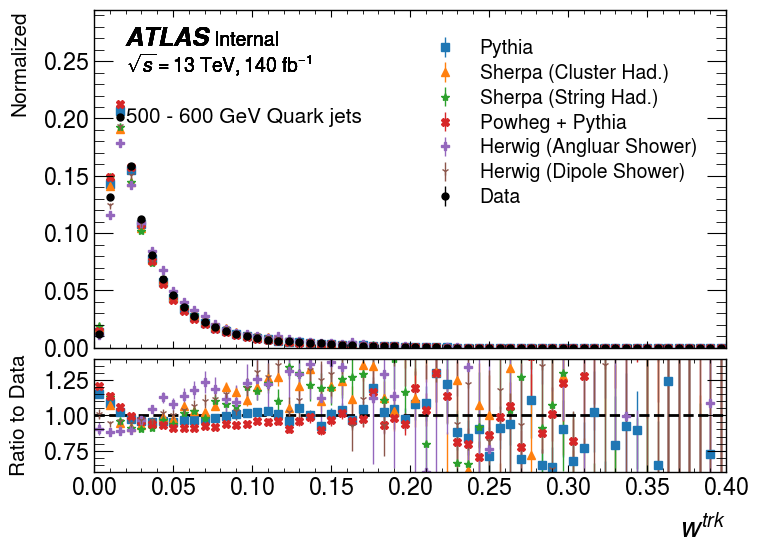

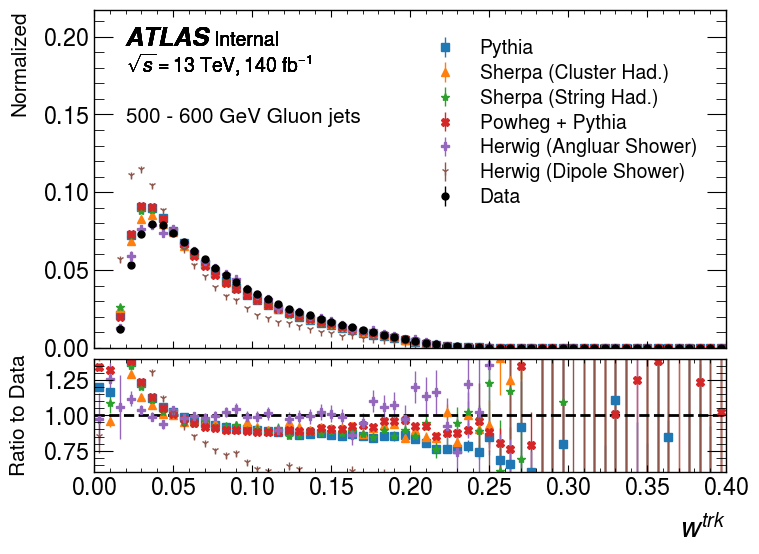

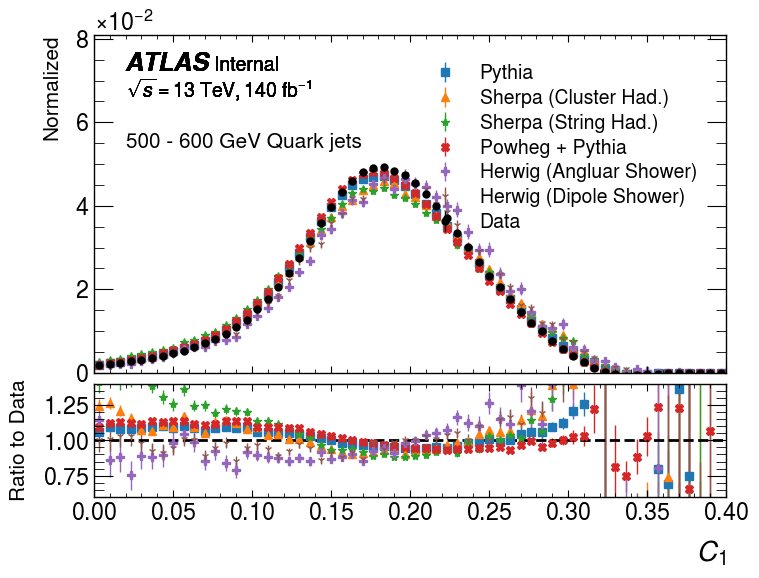

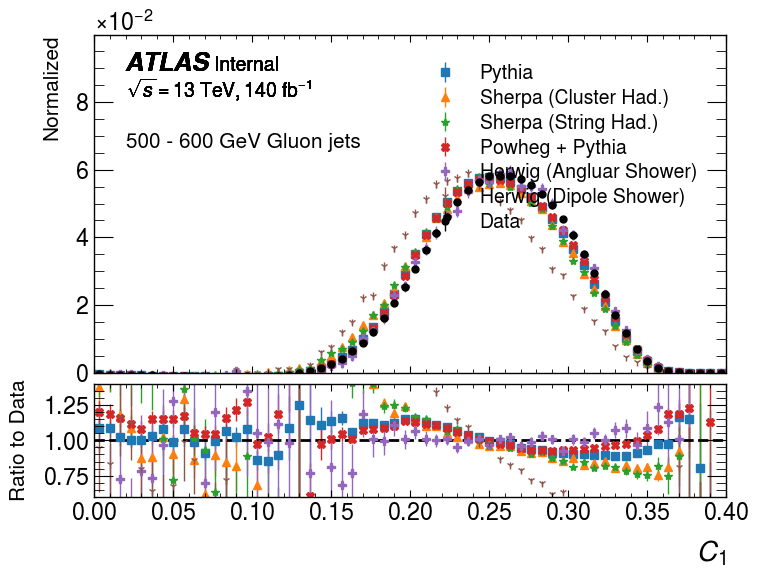

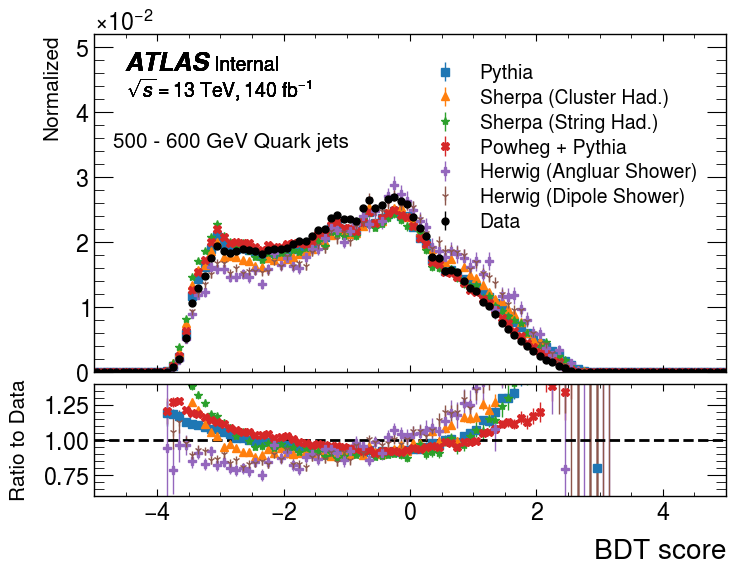

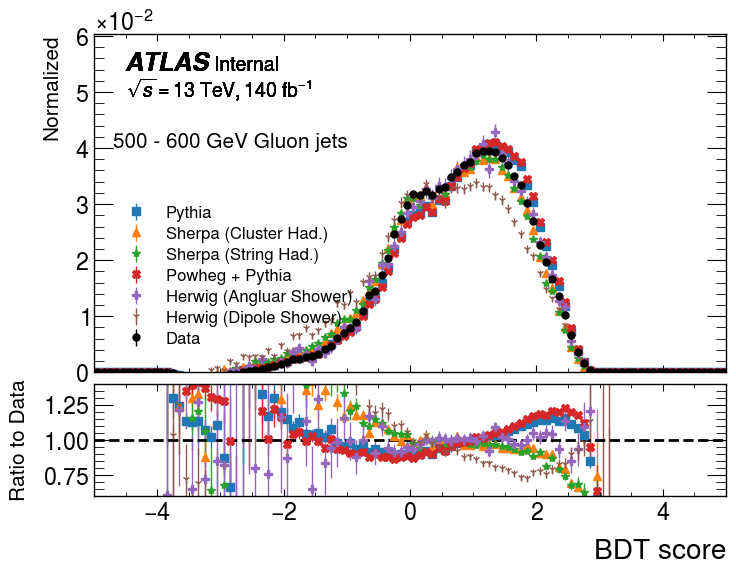

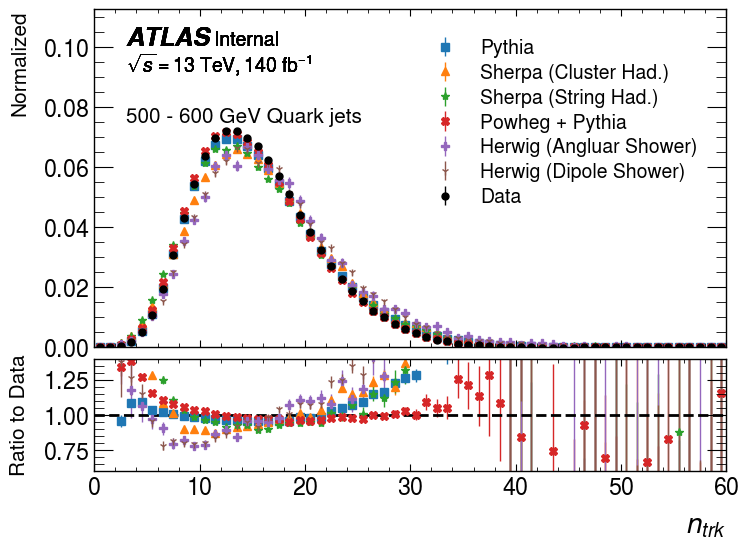

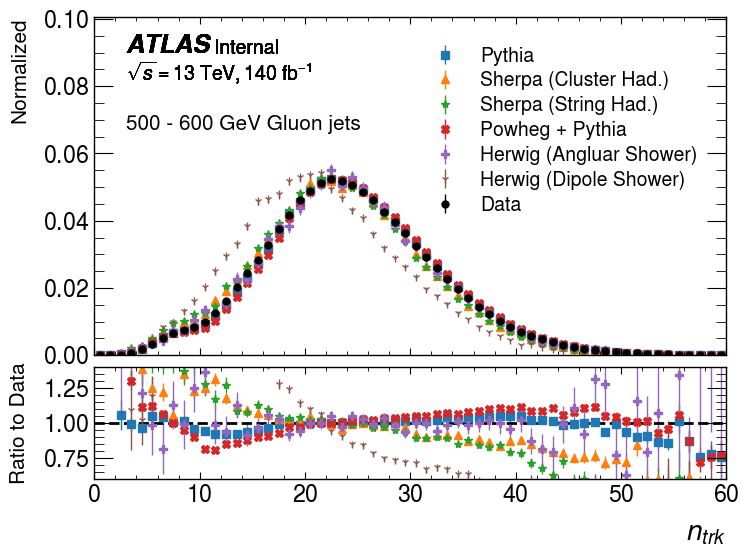

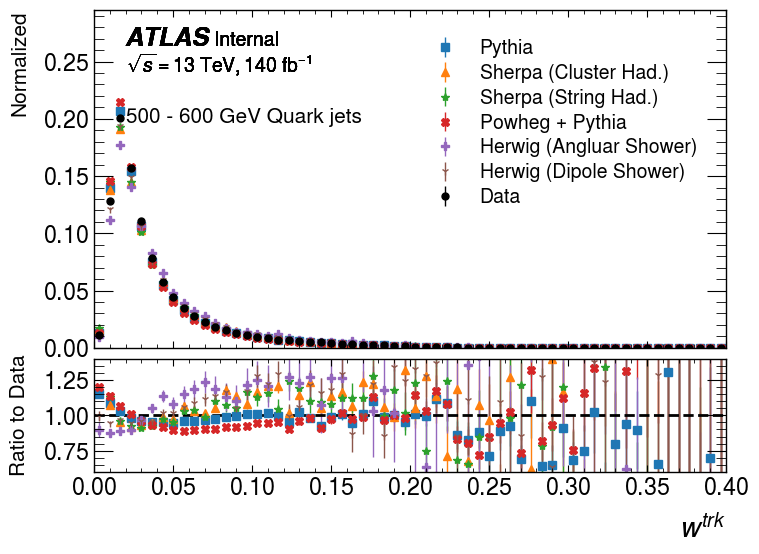

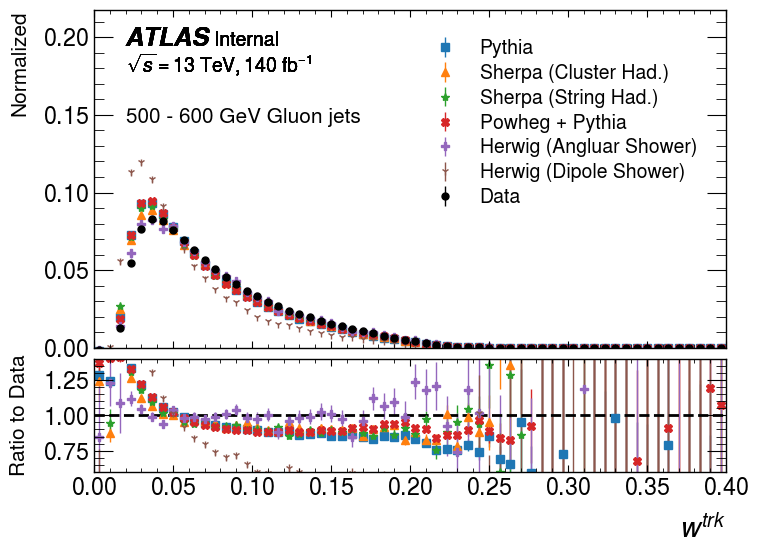

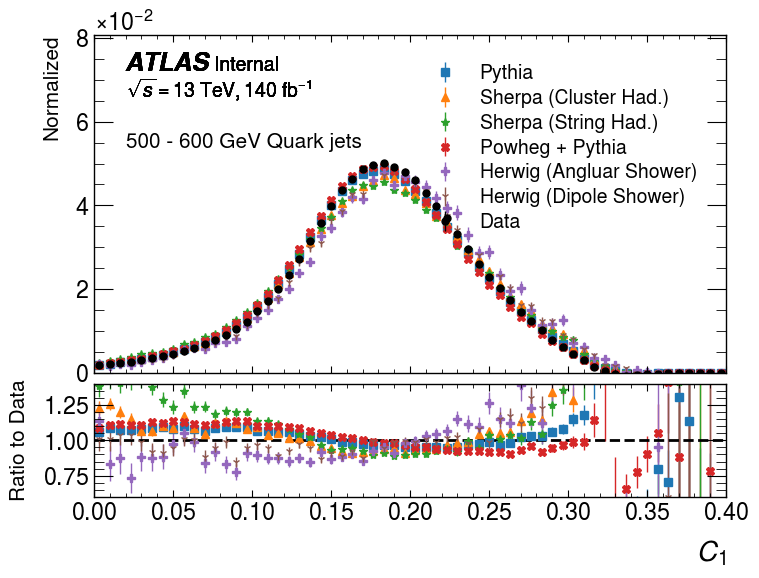

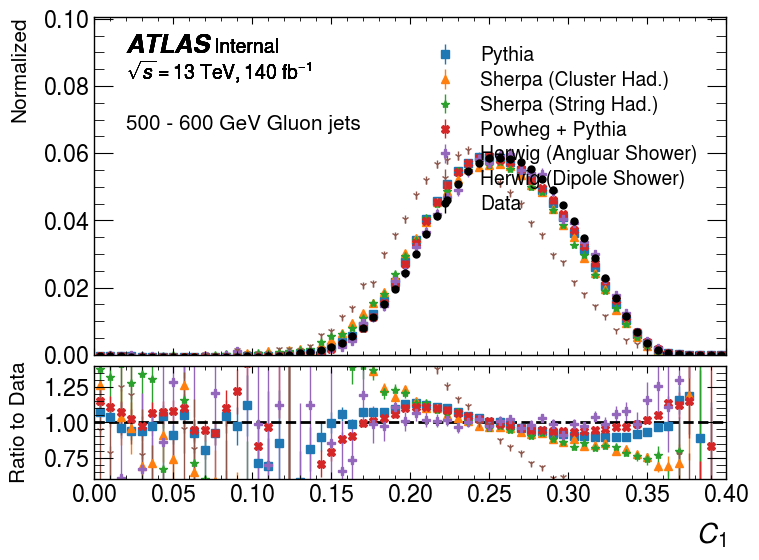

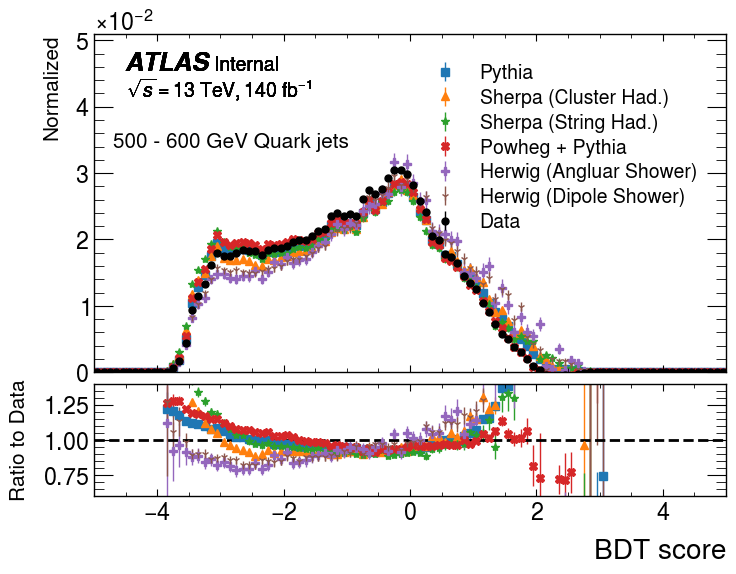

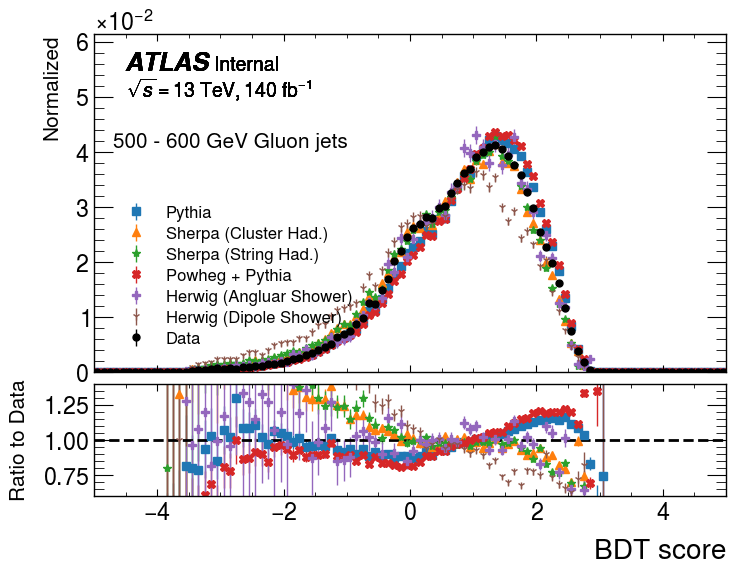

In [7]:
SFs = {}
Extraction_Results={}
syst_list=['nominal','hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']

label_var = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']

for i_pt, pt in enumerate(label_ptrange[:1]):
    for rvar in reweighting_vars[1:]:
        for var in label_var:
            bin_edges = HistBins[var]
            #bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
            for parton in partons:
                #fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.1})
                fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

                for i, syst in enumerate(syst_list):
                    syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
                    Extraction_Results[syst]= joblib.load(syst_path / f'{rvar}_Extraction_Results.pkl' )
                
                    Extraction_var_pt =  Extraction_Results[syst][var][pt]
        
                    syst_truth = Extraction_Results[syst][var][pt][f'p_{parton}']        
                    syst_Q = Extraction_Results[syst][var][pt][f'extract_p_{parton}_MC']
                    syst_data=Extraction_Results[syst][var][pt][f'extract_p_{parton}_Data']
                    nom_data=Extraction_Results['nominal'][var][pt][f'extract_p_{parton}_Data']

                    y_max = np.max(unumpy.nominal_values(syst_truth))


                    #hep.histplot(unumpy.nominal_values(syst_truth),bins=bin_edges,label=f'Truth {syst}',ax=ax0,histtype='step',linestyle='--')
                    #hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=f'Extracted {syst}',ax=ax0,histtype='step',linestyle='-')
                    hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=Map_gen[syst],ax=ax0,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(syst_Q),markersize=6)#,color=ind_all[i])

                
                    ax0.set_ylim(0, y_max * 1.8)
                    ytext=y_max * 1.2
                    ax0.set_ylabel("Normalized",fontsize=15)
                    hep.atlas.label(label='Internal',ax=ax0,data=True,lumi=140)

                    ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,nom_data)

                    #ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,syst_truth)
                    hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),markersize=6)
                    #hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),xerr=True,markersize=4)
                hep.histplot(unumpy.nominal_values(nom_data),bins=bin_edges,label='Data',ax=ax0,histtype='errorbar',marker="o",color='black',yerr=unumpy.std_devs(nom_data),markersize=5)

                ax1.set_ylim(0.6,1.4)
                    #ax2.set_ylim(0.6,1.4)
                #ax1.set_ylabel("MC closure",loc='center',fontsize=15)
                ax1.set_ylabel("Ratio to Data",loc='center',fontsize=15)
                    #ax1.set_ylabel(r"$\frac{Extracted~MC}{Truth~MC}$",loc='center')
                    #ax2.set_ylabel(r"$\frac{Data}{MC}$",loc='center')
                if var == 'GBDT_newScore' and parton == 'Gluon':
                    ax0.legend(loc='lower left',fontsize=12)
                else:
                    ax0.legend(loc='upper right')

                ax0.text(bin_edges[3],ytext,f'{pt} - {label_ptrange[i_pt+1]} GeV {parton}-jets',fontsize=15)
                ax1.set_xlim(bin_edges[0], bin_edges[-1])
                ax1.set_xlabel(f"{Map_var_title[var]}")
                ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
                #ax2.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

                fig.savefig(f'../mcclosure_gen/mcclosure_{rvar}_{var}_{parton}_{pt}_data.pdf')
                    #fig.savefig(f'./mcclosure_sf/mcclosure_{var}_{parton}_{pt}_SF.pdf')



KeyError: 500

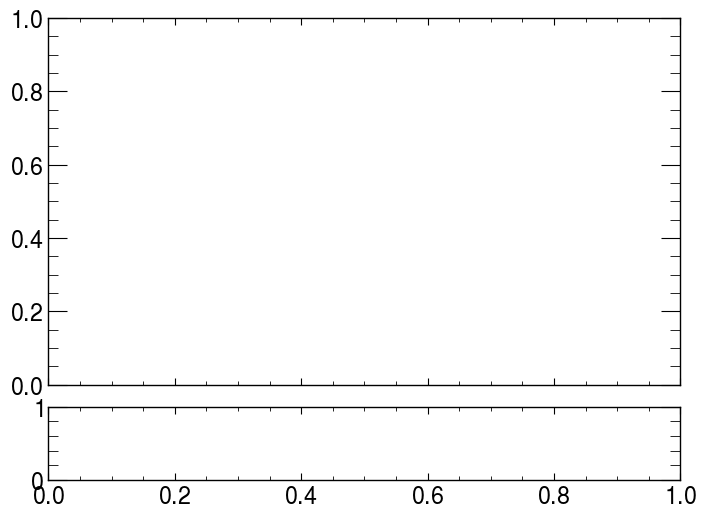

In [4]:
### for eta bin


SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for i_pt, pt in enumerate(label_ptrange[:-1]):#label_ptrange[:-1]
    for rvar in reweighting_vars[1:]:
        #bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        for parton in partons:
            #fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

            for i, syst in enumerate(syst_list):
                nominal_path=Path('/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots/nominal/plots/ADE/Extraction_Results')
                syst_path= Path('/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/eta_dependency_eta_bin/nominal_eta_binned/nominal/nominal/plots/ADE/Extraction_Results')
                Extraction_Results[syst]= joblib.load(nominal_path / f'{rvar}_Extraction_Results.pkl' )
                Extraction_Results_eta = joblib.load(syst_path / f'{rvar}_Extraction_Results.pkl' ) 

                for var in label_var: 
                    bin_edges = HistBins[var]
                    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [5, 1], 'hspace': 0.1})


                    Extraction_var_pt =  Extraction_Results[syst][var][pt]
                    Extraction_var_pt_eta =  Extraction_Results_eta[var][pt]
        
                    syst_truth = Extraction_Results[syst][var][pt][f'p_{parton}']        
                    syst_Q = Extraction_Results[syst][var][pt][f'extract_p_{parton}_MC']
                    syst_Q_eta = Extraction_var_pt_eta[f'extract_p_{parton}_MC']
                    syst_data=Extraction_Results_eta[var][pt][f'extract_p_{parton}_Data']
                    nom_data=Extraction_Results['nominal'][var][pt][f'extract_p_{parton}_Data']

                    y_max = np.max(unumpy.nominal_values(syst_truth))


                    #hep.histplot(unumpy.nominal_values(syst_truth),bins=bin_edges,label=f'Truth Pythia',ax=ax0,histtype='step',linestyle='--',lw=3)
                    hep.histplot(unumpy.nominal_values(syst_Q_eta),bins=bin_edges,label=f'Extracted Pythia (eta)',ax=ax0,histtype='errorbar',color='red',mfc='none',marker="^",yerr=unumpy.std_devs(syst_Q_eta))
                    hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=f'Extracted Pythia',ax=ax0,histtype='errorbar',color='red',marker="^",yerr=unumpy.std_devs(syst_Q))
                    #hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=Map_gen[syst],ax=ax0,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(syst_Q),markersize=5)#,color=ind_all[i])
                    hep.histplot(unumpy.nominal_values(syst_data),bins=bin_edges,label='Extracted Data (eta)',ax=ax0,histtype='errorbar',marker="o",mfc='none',color='b',xerr=True,yerr=unumpy.std_devs(syst_data),markersize=6)
                    hep.histplot(unumpy.nominal_values(nom_data),bins=bin_edges,label='Extracted Data',ax=ax0,histtype='errorbar',marker="o",color='b',xerr=True,yerr=unumpy.std_devs(nom_data),markersize=6)

                
                    ax0.set_ylim(0, y_max * 2)
                    ytext=y_max * 1.4
                    ax0.set_ylabel("Normalized",fontsize=20)
                    hep.atlas.label(label='Internal',ax=ax0,data=True,lumi=140)

                    # ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(syst_Q,nom_data)

                    # ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,syst_truth)
                    # ratio_truthMC_over_extractedMC3 = safe_array_divide_unumpy(syst_Q_none,syst_truth)
                    # hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC3),bins=bin_edges,ax=ax1,label='No re-weight',histtype='step',color='red',linestyle='-.',lw=3)

                    # hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='step',label='Re-weighted',color='orange',linestyle='-',lw=3)
                    # hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC2),bins=bin_edges,ax=ax2,histtype='errorbar',marker="o",xerr=True,color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC2),markersize=6)

                    ax1.set_ylim(0.58,1.42)
                    #ax1.legend()
                    #ax1.set_ylabel("MC closure",loc='center',fontsize=15)
                    #ax1.set_ylabel("Ratio to Data",loc='center',fontsize=15)
                    ax1.set_ylabel(r"$\frac{Ext.MC}{Truth~MC}$",loc='center',fontsize=19)
                    ax0.legend(loc='upper right',fontsize=15)
                    # if var == 'GBDT_newScore' and parton == 'Gluon':
                    #     ax0.legend(loc='lower left',fontsize=15)
                    # else:
                    #     ax0.legend(loc='upper right',fontsize=15)

                    ax0.text(bin_edges[3],ytext,f'{pt} - {label_ptrange[i_pt+1]} GeV',fontsize=15)
                    ax0.text(bin_edges[3],ytext*0.9,f'{parton}-jets',fontsize=15)
                    ax1.set_xlim(bin_edges[0], bin_edges[-1])
                    ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

                    fig.savefig(f'../mcclosure_etabin/mcclosure_{rvar}_{parton}_{pt}_{var}_SF.pdf')
         